In [ ]:
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

In [1]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Time Series Modeling

## Decomposing time series

### How to do it...

1. Import the libraries:

In [3]:
!pip install quandl

In [4]:
import pandas as pd
import quandl
from statsmodels.tsa.seasonal import seasonal_decompose

2. Download the prices of gold for years 2000-2011 and resample to monthly values:

In [5]:
QUANDL_KEY = 'yz7qGzikAuQL9wn7rrX-' # replace {key} with your own API key  
quandl.ApiConfig.api_key = QUANDL_KEY

df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',
                start_date='2000-01-01', 
                end_date='2011-12-31')

df.rename(columns={'Value': 'price'}, inplace=True)
df = df.resample('M').last()

In [6]:
print(f'Shape of DataFrame: {df.shape}')
df.head()

Shape of DataFrame: (144, 1)


price
Date              
2000-01-31  284.31
2000-02-29  299.86
2000-03-31  286.39
2000-04-30  279.69
2000-05-31  275.19

3. Add rolling mean and standard deviation:

In [8]:
WINDOW_SIZE = 12 # 12 month is 1 year
df['rolling_mean'] = df.price.rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df.price.rolling(window=WINDOW_SIZE).std()
df

price  rolling_mean  rolling_std
Date                                          
2000-01-31   284.31           NaN          NaN
2000-02-29   299.86           NaN          NaN
2000-03-31   286.39           NaN          NaN
2000-04-30   279.69           NaN          NaN
2000-05-31   275.19           NaN          NaN
...             ...           ...          ...
2011-08-31  1755.81   1447.342500   130.729234
2011-09-30  1771.85   1489.081667   148.105291
2011-10-31  1665.21   1516.014167   148.316826
2011-11-30  1738.98   1546.771667   153.441103
2011-12-31  1652.31   1568.585000   147.712610

[144 rows x 3 columns]

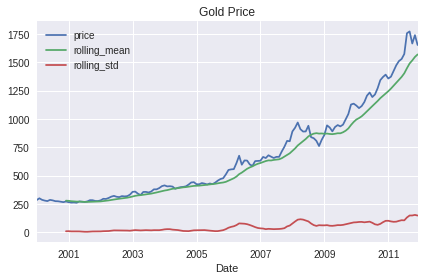

In [9]:
df.plot(title='Gold Price')

plt.tight_layout()
#plt.savefig('images/ch3_im1.png')
plt.show()

4. Carry out seasonal decomposition using the multiplicative model:

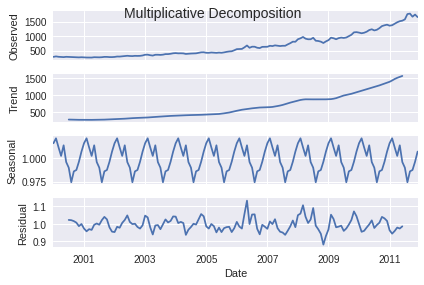

In [12]:
decomposition_results = seasonal_decompose(df.price, 
                                           model='multiplicative')
decomposition_results.plot() \
                     .suptitle('Multiplicative Decomposition', 
                               fontsize=14)

plt.tight_layout()
# plt.savefig('images/ch3_im2.png')
plt.show()

In the decomposition plot, we can see the extracted component series: trend,
seasonal, and random (residual). To evaluate whether the decomposition makes
sense, we can look at the random component. If there is no discernible pattern (in
other words, the random component is indeed random), then the fit makes sense.
For example, if we would have applied the additive model, there would be an
increasing pattern in the residuals over time. In this case, it looks like the variance
in the residuals is slightly higher in the second half of the datase

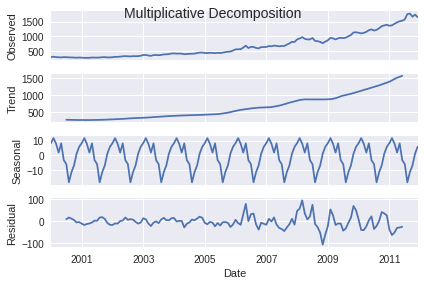

In [13]:
decomposition_results = seasonal_decompose(df.price, 
                                           model='additive')
decomposition_results.plot() \
                     .suptitle('Multiplicative Decomposition', 
                               fontsize=14)

plt.tight_layout()
# plt.savefig('images/ch3_im2.png')
plt.show()

## Decomposing time series using Facebook's Prophet

### How to do it...

1. Import the libraries and authenticate with Quandl:

In [19]:
import pandas as pd
import seaborn as sns
import quandl
from fbprophet import Prophet

QUANDL_KEY = 'yz7qGzikAuQL9wn7rrX-' # replace {key} with your own API key 
quandl.ApiConfig.api_key = QUANDL_KEY

2. Download the daily gold prices and rename the columns:

In [20]:
df = quandl.get(dataset='WGC/GOLD_DAILY_USD',
                start_date='2000-01-01',
                end_date='2005-12-31')

df.reset_index(drop=False, inplace=True)
df.rename(columns={'Date': 'ds', 'Value': 'y'}, inplace=True)
df

ds       y
0    2000-01-03  290.25
1    2000-01-04  281.50
2    2000-01-05  280.45
3    2000-01-06  279.40
4    2000-01-07  282.10
...         ...     ...
1560 2005-12-26  500.00
1561 2005-12-27  500.00
1562 2005-12-28  518.00
1563 2005-12-29  513.00
1564 2005-12-30  513.00

[1565 rows x 2 columns]

3. Split the series into the training and test sets:

In [21]:
train_indices = df.ds.apply(lambda x: x.year).values < 2005
df_train = df.loc[train_indices].dropna()
df_test = df.loc[~train_indices].reset_index(drop=True)

In [26]:
print(df_train.shape)
print(df_test.shape)

(1305, 2)
(260, 2)


In [31]:
df_test

ds       y
0   2005-01-03  435.60
1   2005-01-04  427.75
2   2005-01-05  426.00
3   2005-01-06  424.35
4   2005-01-07  422.20
..         ...     ...
255 2005-12-26  500.00
256 2005-12-27  500.00
257 2005-12-28  518.00
258 2005-12-29  513.00
259 2005-12-30  513.00

[260 rows x 2 columns]

4. Create the instance of the model and fit it to the data:

In [22]:
model_prophet = Prophet(seasonality_mode='additive')
model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_prophet.fit(df_train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5. Forecast the gold prices 1 year ahead and plot the results:

In [28]:
df_future = model_prophet.make_future_dataframe(periods=365)
df_future

ds
0    2000-01-03
1    2000-01-04
2    2000-01-05
3    2000-01-06
4    2000-01-07
...         ...
1665 2005-12-27
1666 2005-12-28
1667 2005-12-29
1668 2005-12-30
1669 2005-12-31

[1670 rows x 1 columns]

In [29]:
df_pred = model_prophet.predict(df_future)
df_pred

ds       trend  ...  multiplicative_terms_upper        yhat
0    2000-01-03  274.430138  ...                         0.0  289.297094
1    2000-01-04  274.568773  ...                         0.0  289.376874
2    2000-01-05  274.707407  ...                         0.0  288.742939
3    2000-01-06  274.846042  ...                         0.0  288.348620
4    2000-01-07  274.984677  ...                         0.0  288.766444
...         ...         ...  ...                         ...         ...
1665 2005-12-27  469.237705  ...                         0.0  483.270741
1666 2005-12-28  469.341937  ...                         0.0  482.783305
1667 2005-12-29  469.446169  ...                         0.0  482.955555
1668 2005-12-30  469.550400  ...                         0.0  484.001523
1669 2005-12-31  469.654632  ...                         0.0  494.686198

[1670 rows x 22 columns]

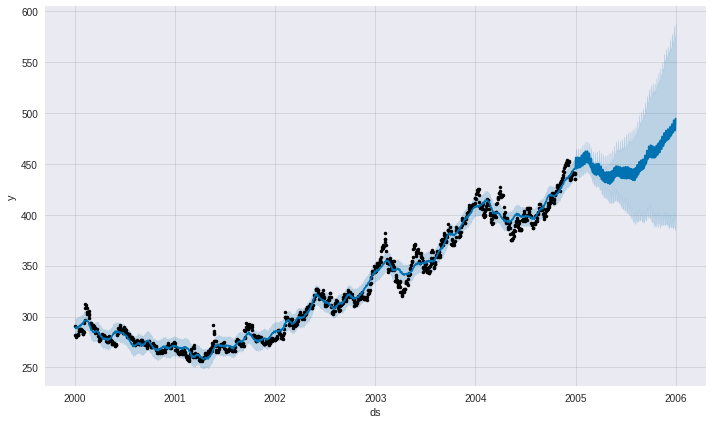

In [30]:
model_prophet.plot(df_pred)

plt.tight_layout()
#plt.savefig('images/ch3_im3.png')
plt.show()

The black dots are the actual observations of the gold price. The blue line
representing the fit does not match the observations exactly, as the model
smooths out the noise in the data (also reducing the chance of overfitting). An
important feature is that Prophet quantifies uncertainty, which is represented by
the blue intervals around the fitted line.

6. Inspect the decomposition of the time series:

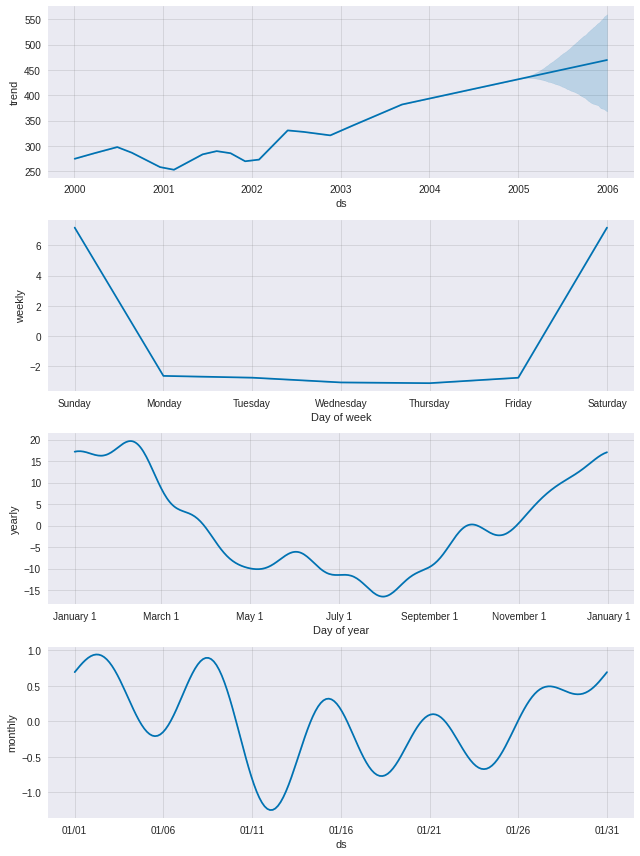

In [24]:
model_prophet.plot_components(df_pred)

plt.tight_layout()
#plt.savefig('images/ch3_im4.png')
plt.show()

Upon closer inspection, we can see that the overall trend is increasing and that the
gold price seems to be higher during the beginning and the end of the year, with a
dip in the summer. On the monthly level, there is some movement, but the scale is
much smaller than in the case of the yearly pattern. There is not a lot of
movement in the weekly chart (we do not look at weekends as there are no prices
for weekends), which makes sense because, with a decrease in the time scale, the
noise starts to wash out the signal. For this reason, we might disable the weekly
level altogether

### There's more...

1. Merge the test set with the forecasts:

In [32]:
selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']

df_pred = df_pred.loc[:, selected_columns].reset_index(drop=True)
df_test = df_test.merge(df_pred, on=['ds'], how='left')
df_test.ds = pd.to_datetime(df_test.ds)
df_test.set_index('ds', inplace=True)

We merged the test set with the prediction DataFrame. We used a left join, which
returns all the rows from the left table (test set) and the matched rows from the
right table (prediction DataFrame) while leaving the unmatched rows empty. This
way, we also kept only the dates that were in the test set (Prophet created
predictions for the next 365 days, including weekends and potential holidays)

In [33]:
df_test

y  yhat_lower  yhat_upper        yhat
ds                                                    
2005-01-03  435.60  436.096077  454.244379  445.365416
2005-01-04  427.75  436.140512  454.303078  445.549590
2005-01-05  426.00  436.703942  455.158377  446.015925
2005-01-06  424.35  437.596341  455.651543  446.622739
2005-01-07  422.20  437.893430  456.516115  447.055414
...            ...         ...         ...         ...
2005-12-26  500.00  390.032052  573.775879  483.530388
2005-12-27  500.00  387.466090  572.917962  483.270741
2005-12-28  518.00  388.433049  575.627268  482.783305
2005-12-29  513.00  385.129541  575.563331  482.955555
2005-12-30  513.00  384.630883  576.052870  484.001523

[260 rows x 4 columns]

2. Plot the test values vs. predictions:

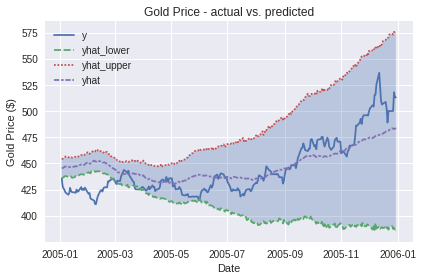

In [34]:
fig, ax = plt.subplots(1, 1)

ax = sns.lineplot(data=df_test[['y', 'yhat_lower', 
                                'yhat_upper', 'yhat']])
ax.fill_between(df_test.index,
                df_test.yhat_lower,
                df_test.yhat_upper,
                alpha=0.3)
ax.set(title='Gold Price - actual vs. predicted',
       xlabel='Date',
       ylabel='Gold Price ($)')

plt.tight_layout()
#plt.savefig('images/ch3_im5.png')
plt.show()

From the preceding plot, we can see that Prophet accurately (at least visually)
predicted the price of gold over 2005. It was only over the first two months that
the observed prices were outside of the confidence interval.

## Testing for stationarity in time series

### How to do it...

0: Download the data:

In [ ]:
import pandas as pd
import quandl

In [35]:
QUANDL_KEY = 'yz7qGzikAuQL9wn7rrX-' # replace {key} with your own API key  
quandl.ApiConfig.api_key = QUANDL_KEY

df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',
                start_date='2000-01-01', 
                end_date='2011-12-31')

df.rename(columns={'Value': 'price'}, inplace=True)
df = df.resample('M').last()
df

price
Date               
2000-01-31   284.31
2000-02-29   299.86
2000-03-31   286.39
2000-04-30   279.69
2000-05-31   275.19
...             ...
2011-08-31  1755.81
2011-09-30  1771.85
2011-10-31  1665.21
2011-11-30  1738.98
2011-12-31  1652.31

[144 rows x 1 columns]

1. Import the libraries:

In [36]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

2. Define a function for running the ADF test:

In [37]:
def adf_test(x):
    '''
    Function for performing the Augmented Dickey-Fuller test for stationarity
    
    Null Hypothesis: time series is not stationary
    Alternate Hypothesis: time series is stationary

    Parameters
    ----------
    x : pd.Series / np.array
        The time series to be checked for stationarity
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the ADF test's results
    '''
    
    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']
    
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    return results


In [38]:
adf_test(df.price)

Test Statistic              3.510499
p-value                     1.000000
# of Lags Used             14.000000
# of Observations Used    129.000000
Critical Value (1%)        -3.482088
Critical Value (5%)        -2.884219
Critical Value (10%)       -2.578864
dtype: float64

The null hypothesis of the ADF test states that the time series is not stationary.
With a p-value of 1 (or equivalently, the test statistic larger than the critical value
for the selected confidence level), we have no reason to reject the null hypothesis,
meaning that we can conclude that the series is not stationary.

3. Define a function for running the KPSS test:

In [39]:
def kpss_test(x, h0_type='c'):
    '''
    Function for performing the Kwiatkowski-Phillips-Schmidt-Shin test for stationarity

    Null Hypothesis: time series is stationary
    Alternate Hypothesis: time series is not stationary

    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the KPSS test's results
    '''
    
    indices = ['Test Statistic', 'p-value', '# of Lags']

    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value

    return results

In [40]:
kpss_test(df.price)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



Test Statistic            0.985671
p-value                   0.010000
# of Lags                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

The null hypothesis of the KPSS test is that the time series is stationary. With a pvalue of 0.01 (or test statistic greater than the selected critical value), we have
reasons to reject the null hypothesis in favor of the alternative one, meaning that
the series is not stationary.

4. Generate the ACF/PACF plots:

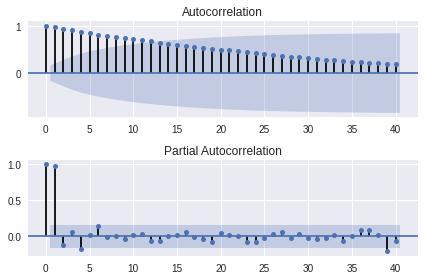

In [41]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2, 1)
plot_acf(df.price, ax=ax[0], lags=N_LAGS, 
         alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df.price, ax=ax[1], lags=N_LAGS, 
          alpha=SIGNIFICANCE_LEVEL)

plt.tight_layout()
#plt.savefig('images/ch3_im8.png')
plt.show()

In the ACF plot, we can see that there are significant autocorrelations (above the
95% confidence interval, corresponding to the selected 5% significance level).
There are also some significant autocorrelations at lags 1 and 4 in the PACF plot.

## Correcting for stationarity in time series

In this recipe, we investigate how to make a non-stationary time series stationary by using
the following transformations:

- Deflation: Accounting for inflation in monetary series using the Consumer Price
Index (CPI)
- Natural logarithm: Making the exponential trend closer to linear
- Differencing: Taking the difference between the current observation and a
lagged value (observation x time points before it)

We use the same data that we used in the Testing for stationarity in time series recipe. The
conclusion from that recipe was that the time series of monthly gold prices from 2000-2011
was not stationary.

### How to do it...

0: Download the data:

In [3]:
import pandas as pd
import quandl

In [ ]:
QUANDL_KEY = '{yz7qGzikAuQL9wn7rrX-}' # replace {key} with your own API key  
quandl.ApiConfig.api_key = QUANDL_KEY

df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',
                start_date='2000-01-01', 
                end_date='2011-12-31')

df.rename(columns={'Value': 'price'}, inplace=True)
df = df.resample('M').last()
df

In [43]:
df

price
Date               
2000-01-31   284.31
2000-02-29   299.86
2000-03-31   286.39
2000-04-30   279.69
2000-05-31   275.19
...             ...
2011-08-31  1755.81
2011-09-30  1771.85
2011-10-31  1665.21
2011-11-30  1738.98
2011-12-31  1652.31

[144 rows x 1 columns]

1. Import the libraries and update the inflation data:

In [45]:
!pip install cpi

     |████████████████████████████████| 25.5MB 153kB/s 


In [ ]:
import cpi
import pandas as pd
import numpy as np
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
#from chapter_3_utils import test_autocorrelation

# update the CPI data (if needed)
# cpi.update()

In [48]:
def test_autocorrelation(x, n_lags=40, alpha=0.05, h0_type='c'):
    '''
    Function for testing the stationarity of a series by using:
    * the ADF test
    * the KPSS test
    * ACF/PACF plots
    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    n_lags : int
        The number of lags for the ACF/PACF plots
    alpha : float
        Significance level for the ACF/PACF plots
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend
    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure containing the ACF/PACF plot
    '''

    adf_results = adf_test(x)
    kpss_results = kpss_test(x, h0_type=h0_type)

    print('ADF test statistic: {:.2f} (p-val: {:.2f})'.format(adf_results['Test Statistic'],
                                                             adf_results['p-value']))
    print('KPSS test statistic: {:.2f} (p-val: {:.2f})'.format(kpss_results['Test Statistic'],
                                                              kpss_results['p-value']))

    fig, ax = plt.subplots(2, figsize=(16, 8))
    plot_acf(x, ax=ax[0], lags=n_lags, alpha=alpha)
    plot_pacf(x, ax=ax[1], lags=n_lags, alpha=alpha)

    return fig

In [47]:
cpi

<module 'cpi' from '/usr/local/lib/python3.6/dist-packages/cpi/__init__.py'>

2. Deflate the gold prices (to 2011-12-31 USD values) and plot the results:

Deflation: In Step 2, we used the cpi library to account for inflation in the US dollar. The
library relies on the CPI-U index recommended by the Bureau of Labor Statistics. To make
it work, we created an artificial index column containing dates as objects of
the datetime.date class. The inflate function takes the following arguments:

value: The dollar value we want to adjust.

year_or_month: The date that the dollar value comes from.

to: Optionally, the date we want to adjust to. If we don't provide this argument,
the function will adjust to the most recent year.

In [51]:
DEFL_DATE = date(2011, 12, 31)

df['dt_index'] = df.index.map(lambda x: x.to_pydatetime().date())
df['price_deflated'] = df.apply(lambda x: cpi.inflate(x.price,
                                                      x.dt_index, 
                                                      DEFL_DATE), 
                                axis=1)
df

price    dt_index  price_deflated
Date                                           
2000-01-31   284.31  2000-01-31      380.099564
2000-02-29   299.86  2000-02-29      398.527714
2000-03-31   286.39  2000-03-31      377.512874
2000-04-30   279.69  2000-04-30      368.465859
2000-05-31   275.19  2000-05-31      362.114739
...             ...         ...             ...
2011-08-31  1755.81  2011-08-31     1749.043918
2011-09-30  1771.85  2011-09-30     1762.346051
2011-10-31  1665.21  2011-10-31     1659.701490
2011-11-30  1738.98  2011-11-30     1734.690777
2011-12-31  1652.31  2011-12-31     1652.310000

[144 rows x 3 columns]

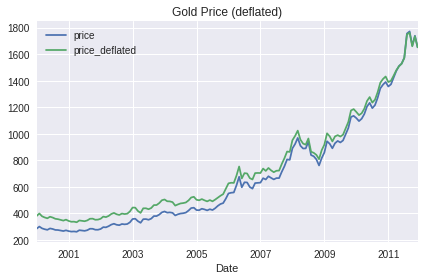

In [52]:
df[['price', 'price_deflated']].plot(title='Gold Price (deflated)')
plt.tight_layout()
#plt.savefig('images/ch3_im9.png')
plt.show()

3. Deflate the series using natural logarithm and plot it together with the rolling metrics:

In [53]:
WINDOW = 12

df['price_log'] = np.log(df.price_deflated)
df['rolling_mean_log'] = df.price_log.rolling(WINDOW) \
                           .mean()
df['rolling_std_log'] = df.price_log.rolling(WINDOW) \
                          .std()

selected_columns = ['price_log', 'rolling_mean_log', 
                    'rolling_std_log']

df[selected_columns]

price_log  rolling_mean_log  rolling_std_log
Date                                                    
2000-01-31   5.940433               NaN              NaN
2000-02-29   5.987777               NaN              NaN
2000-03-31   5.933605               NaN              NaN
2000-04-30   5.909348               NaN              NaN
2000-05-31   5.891961               NaN              NaN
...               ...               ...              ...
2011-08-31   7.466825          7.288477         0.074586
2011-09-30   7.474401          7.313000         0.083560
2011-10-31   7.414393          7.328094         0.084204
2011-11-30   7.458584          7.345193         0.088386
2011-12-31   7.409930          7.357133         0.086467

[144 rows x 3 columns]

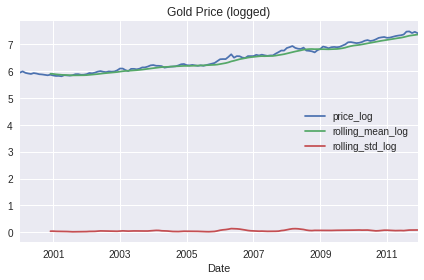

In [54]:
df[selected_columns].plot(title='Gold Price (logged)')

plt.tight_layout()
#plt.savefig('images/ch3_im10.png')
plt.show()

From the preceding plot, we can see that the log transformation did its job, that is,
it made the exponential trend linear.

4. Use the `test_autocorrelation` (helper function for this chapter) to investigate if the series became stationary:

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



ADF test statistic: 0.89 (p-val: 0.99)
KPSS test statistic: 1.04 (p-val: 0.01)


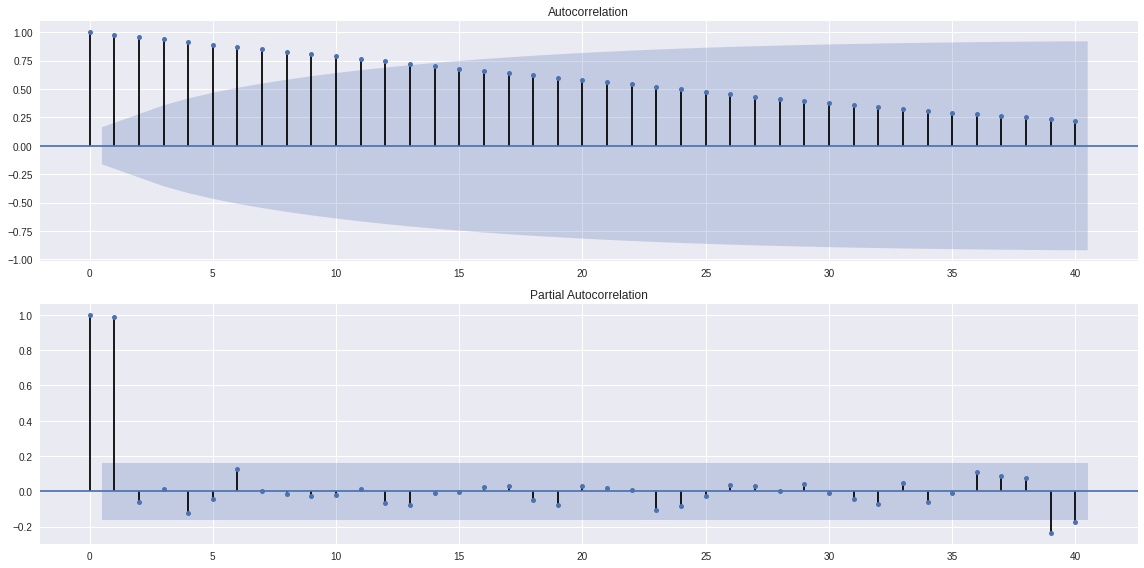

In [55]:
fig = test_autocorrelation(df.price_log)

plt.tight_layout()
#plt.savefig('images/ch3_im11.png')
plt.show()

After inspecting the results of the statistical tests and the ACF/PACF plots, we can
conclude that deflation and a natural algorithm were not enough to make the
gold prices stationary.

5. Apply differencing to the series and plot the results:

In [56]:
selected_columns = ['price_log_diff', 'roll_mean_log_diff', 
                    'roll_std_log_diff']

df['price_log_diff'] = df.price_log.diff(1)
df['roll_mean_log_diff'] = df.price_log_diff.rolling(WINDOW) \
                             .mean()
df['roll_std_log_diff'] = df.price_log_diff.rolling(WINDOW) \
                            .std()
df[selected_columns]

price_log_diff  roll_mean_log_diff  roll_std_log_diff
Date                                                             
2000-01-31             NaN                 NaN                NaN
2000-02-29        0.047344                 NaN                NaN
2000-03-31       -0.054172                 NaN                NaN
2000-04-30       -0.024257                 NaN                NaN
2000-05-31       -0.017387                 NaN                NaN
...                    ...                 ...                ...
2011-08-31        0.107313            0.027542           0.032331
2011-09-30        0.007577            0.024523           0.032367
2011-10-31       -0.060008            0.015094           0.039061
2011-11-30        0.044191            0.017099           0.039950
2011-12-31       -0.048655            0.011940           0.044257

[144 rows x 3 columns]

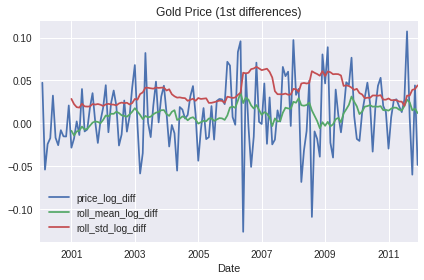

In [57]:
df[selected_columns].plot(title='Gold Price (1st differences)')

plt.tight_layout()
#plt.savefig('images/ch3_im12.png')
plt.show()

The transformed gold prices make the impression of being stationary – the series
oscillates around 0 with more or less constant variance. At least there is no visible
trend.

6. Test if the series became stationary:

ADF test statistic: -9.13 (p-val: 0.00)
KPSS test statistic: 0.37 (p-val: 0.09)


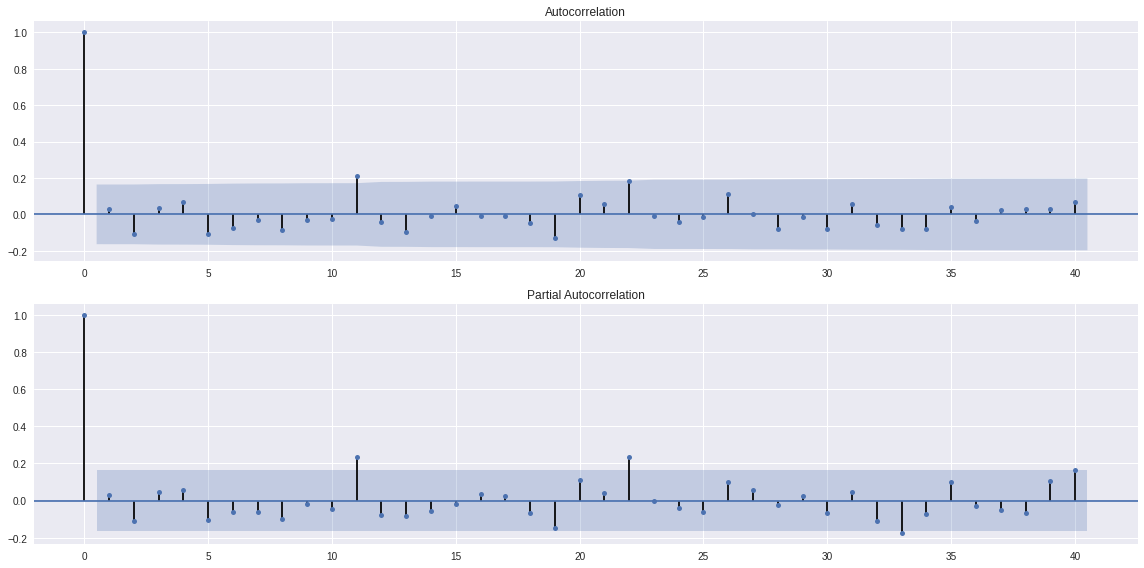

In [58]:
fig = test_autocorrelation(df.price_log_diff.dropna())

plt.tight_layout()
#plt.savefig('images/ch3_im13.png')
plt.show()

After applying the first differences, the series became stationary at the 5%
significance level (according to both tests). In the ACF/PACF plots, we can see
that there was a significant value of the function at lag 11 and 22. This might
indicate some kind of seasonality or simply be a false signal. Using a 5%
significance level means that 5% of the values might lie outside the 95%
confidence interval – even when the underlying process does not show any
autocorrelation or partial autocorrelation

### There's more...

In [ ]:
!pip install yfinance

In [7]:
import pandas as pd 
import yfinance as yf

In [15]:
df = yf.download('GC=F', 
                       start='2000-01-01', 
                       end='2011-12-31',
                       progress=False)
df.rename(columns={'Adj Close':'price'},inplace=True)
df = df.resample('M').last()
df

Open         High  ...        price  Volume
Date                                  ...                     
2000-02-29   292.399994   292.399994  ...   292.399994       7
2000-03-31   275.500000   279.799988  ...   278.399994    3167
2000-04-30   273.100006   273.100006  ...   273.100006       1
2000-05-31   272.799988   272.799988  ...   271.700012   23846
2000-06-30   290.100006   290.100006  ...   290.100006       0
...                 ...          ...  ...          ...     ...
2011-08-31  1830.599976  1837.900024  ...  1828.500000     598
2011-09-30  1620.800049  1639.400024  ...  1620.400024    7181
2011-10-31  1741.900024  1741.900024  ...  1724.199951     158
2011-11-30  1714.000000  1749.199951  ...  1745.500000   64786
2011-12-31  1549.400024  1579.500000  ...  1565.800049     866

[143 rows x 6 columns]

In [ ]:
!pip install pmdarima

In [16]:
from pmdarima.arima import ndiffs, nsdiffs

A library called pmdarima (more on this library can be found in the Modeling time series
with ARIMA class models recipe) contains two functions that employ statistical tests to
determine how many times we should differentiate the series in order to achieve
stationarity (and also remove seasonality, that is, seasonal stationarity)

In [17]:
print(f"Suggested # of differences (ADF): {ndiffs(df.price, test='adf')}")
print(f"Suggested # of differences (KPSS): {ndiffs(df.price, test='kpss')}")
print(f"Suggested # of differences (PP): {ndiffs(df.price, test='pp')}")

Suggested # of differences (ADF): 1
Suggested # of differences (KPSS): 1
Suggested # of differences (PP): 1


In [18]:
print(f"Suggested # of differences (OSCB): {nsdiffs(df.price, m=12, test='ocsb')}")
print(f"Suggested # of differences (CH): {nsdiffs(df.price, m=12, test='ch')}")

Suggested # of differences (OSCB): 0
Suggested # of differences (CH): 0


## Modeling time series with exponential smoothing methods

### Getting Ready

In [ ]:
import seaborn as sns 

plt.set_cmap('cubehelix')
sns.set_palette('cubehelix')

COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]

<Figure size 2400x1650 with 0 Axes>

### How to do it...

1. Import the libraries:

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, 
                                         SimpleExpSmoothing, 
                                         Holt)

2. Download the adjusted stock prices of Google:

In [ ]:
df = yf.download('GOOG',
                 start='2010-01-01',
                 end='2018-12-31',
                 adjusted=True,
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

Downloaded 2264 rows of data.


3. Aggregate to monthly frequency:

In [ ]:
goog = df.resample('M') \
         .last() \
         .rename(columns={'Adj Close': 'adj_close'}) \
         .adj_close 

4. Create the training/test split:

In [ ]:
train_indices = goog.index.year < 2018
goog_train = goog[train_indices]
goog_test = goog[~train_indices]

test_length = len(goog_test)

5. Plot the prices:

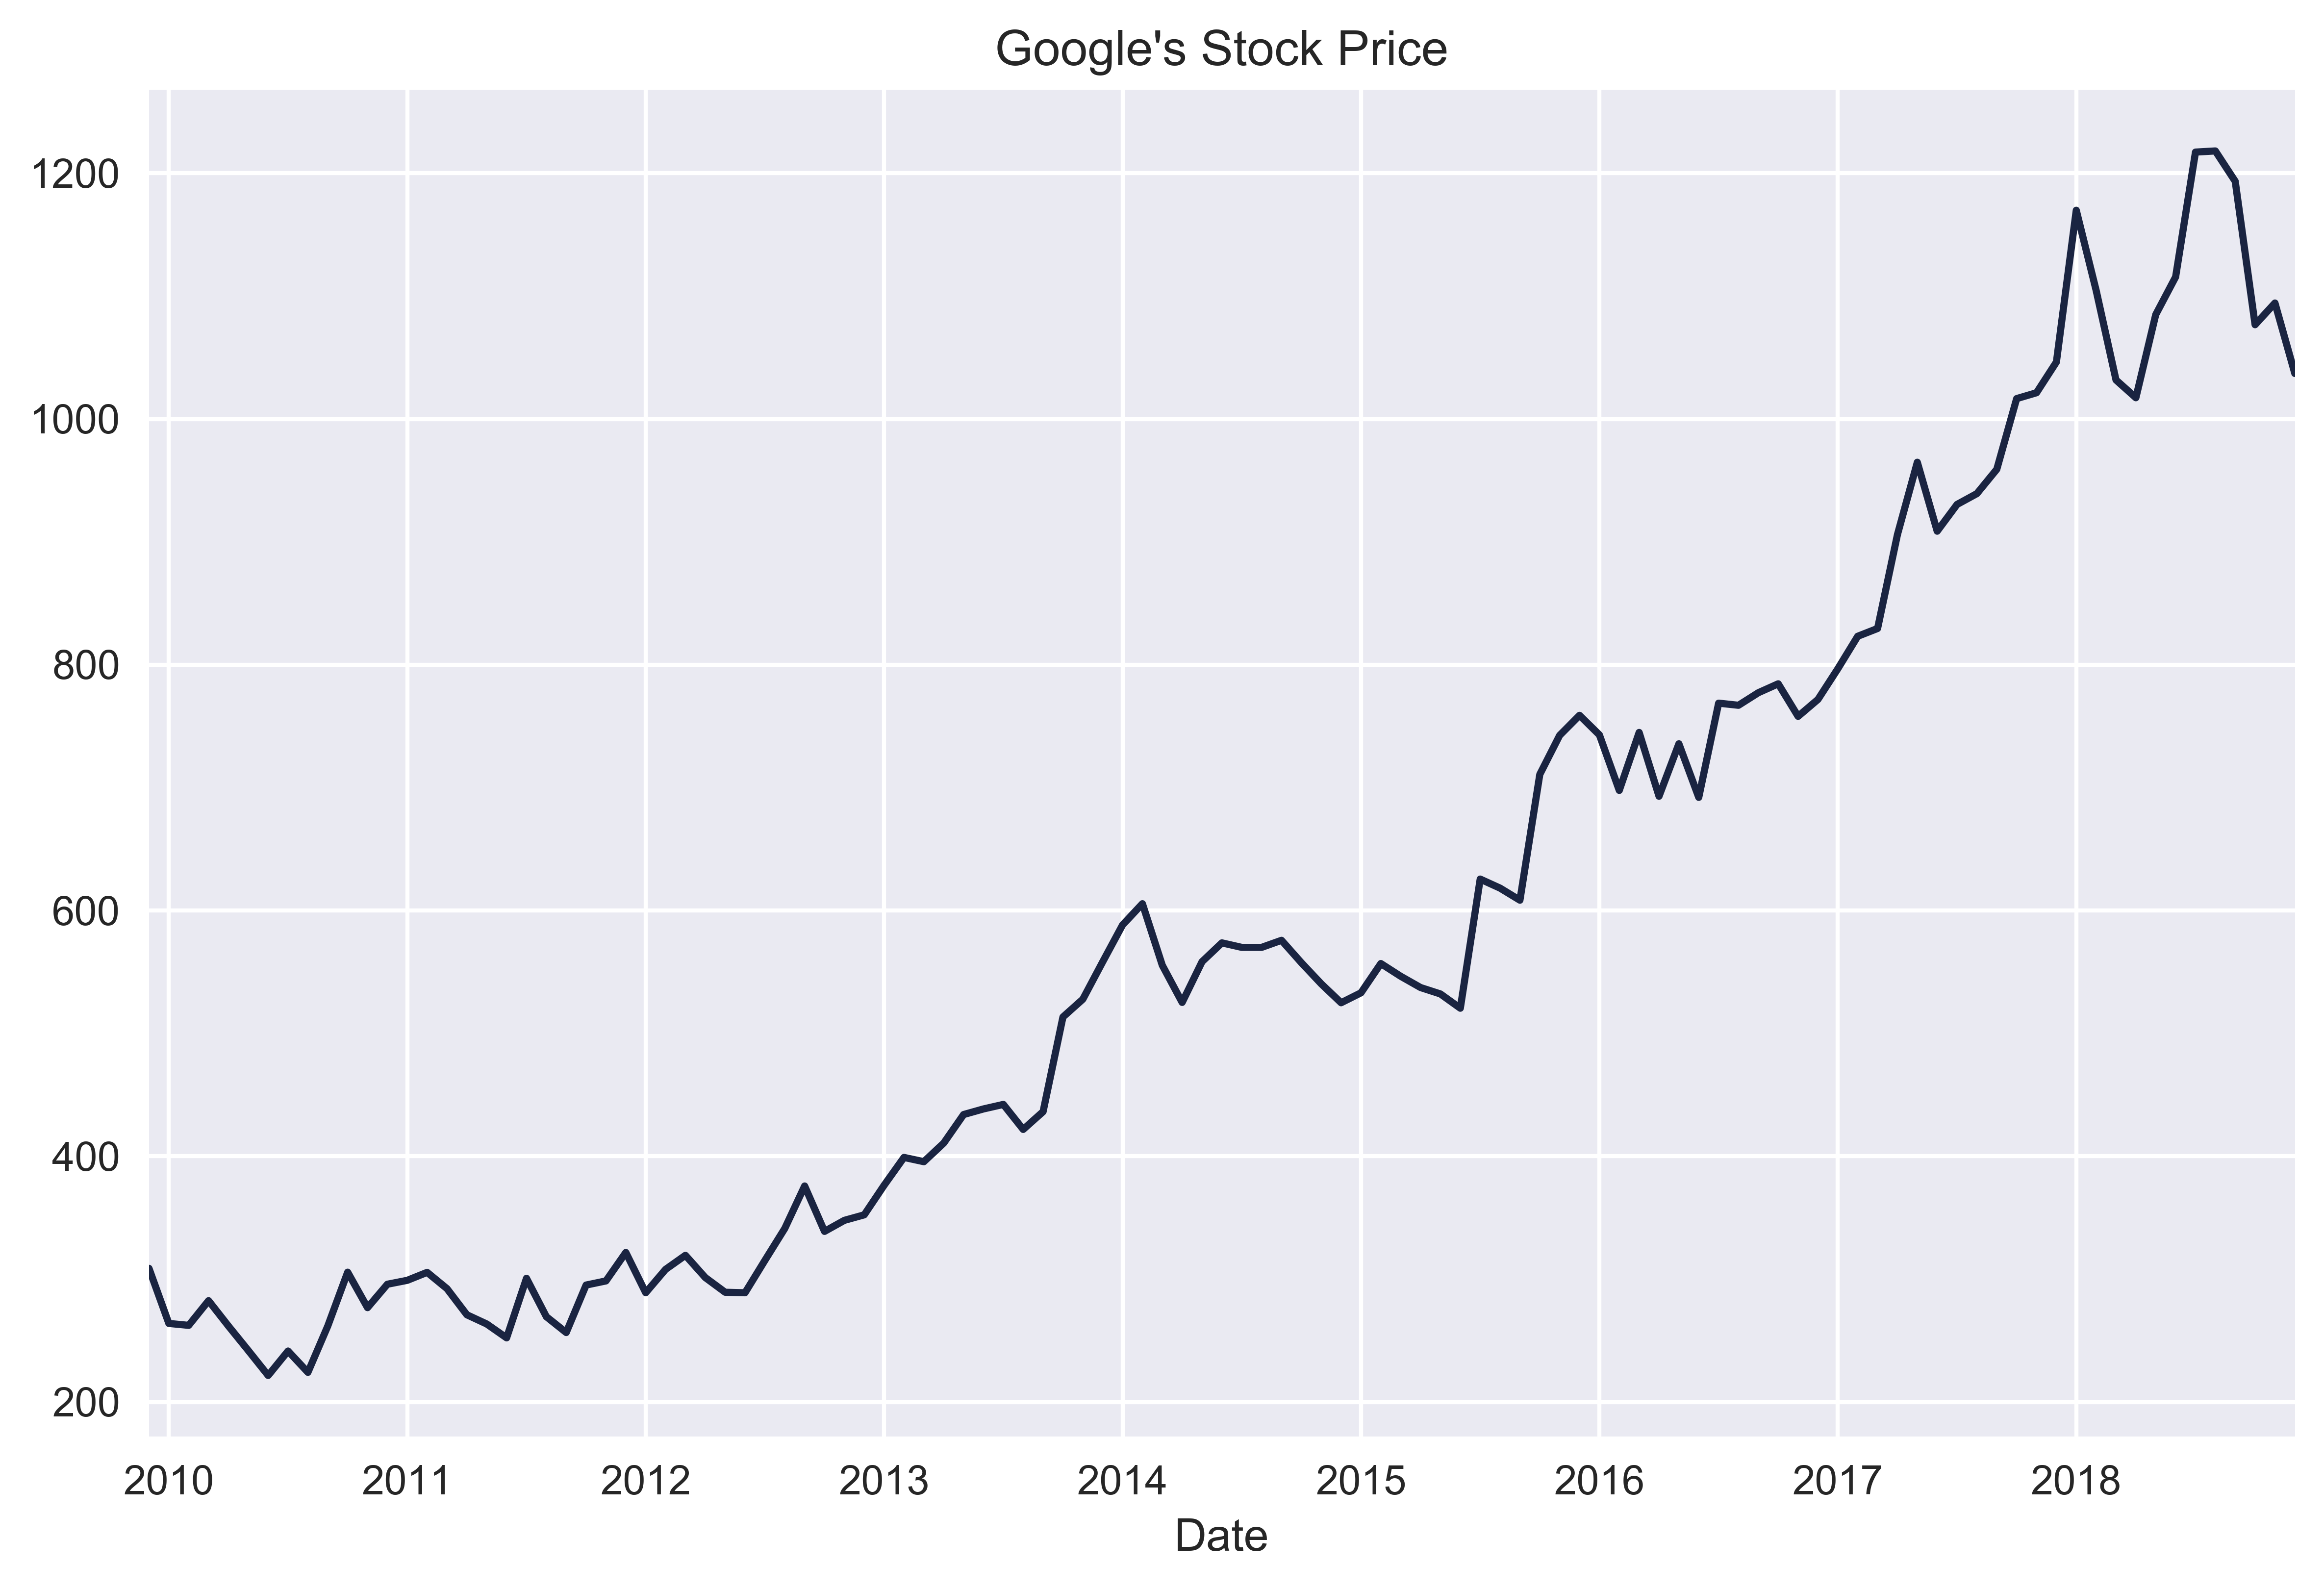

In [ ]:
goog.plot(title="Google's Stock Price")

plt.tight_layout()
#plt.savefig('images/ch3_im14.png')
plt.show()

6. Fit 3 Simple Exponential Smoothing models and create forecasts:

In [ ]:
ses_1 = SimpleExpSmoothing(goog_train).fit(smoothing_level=0.2)
ses_forecast_1 = ses_1.forecast(test_length)

ses_2 = SimpleExpSmoothing(goog_train).fit(smoothing_level=0.5)
ses_forecast_2 = ses_2.forecast(test_length)

ses_3 = SimpleExpSmoothing(goog_train).fit()
alpha = ses_3.model.params['smoothing_level']
ses_forecast_3 = ses_3.forecast(test_length)

7. Plot the original prices together with the models' results:

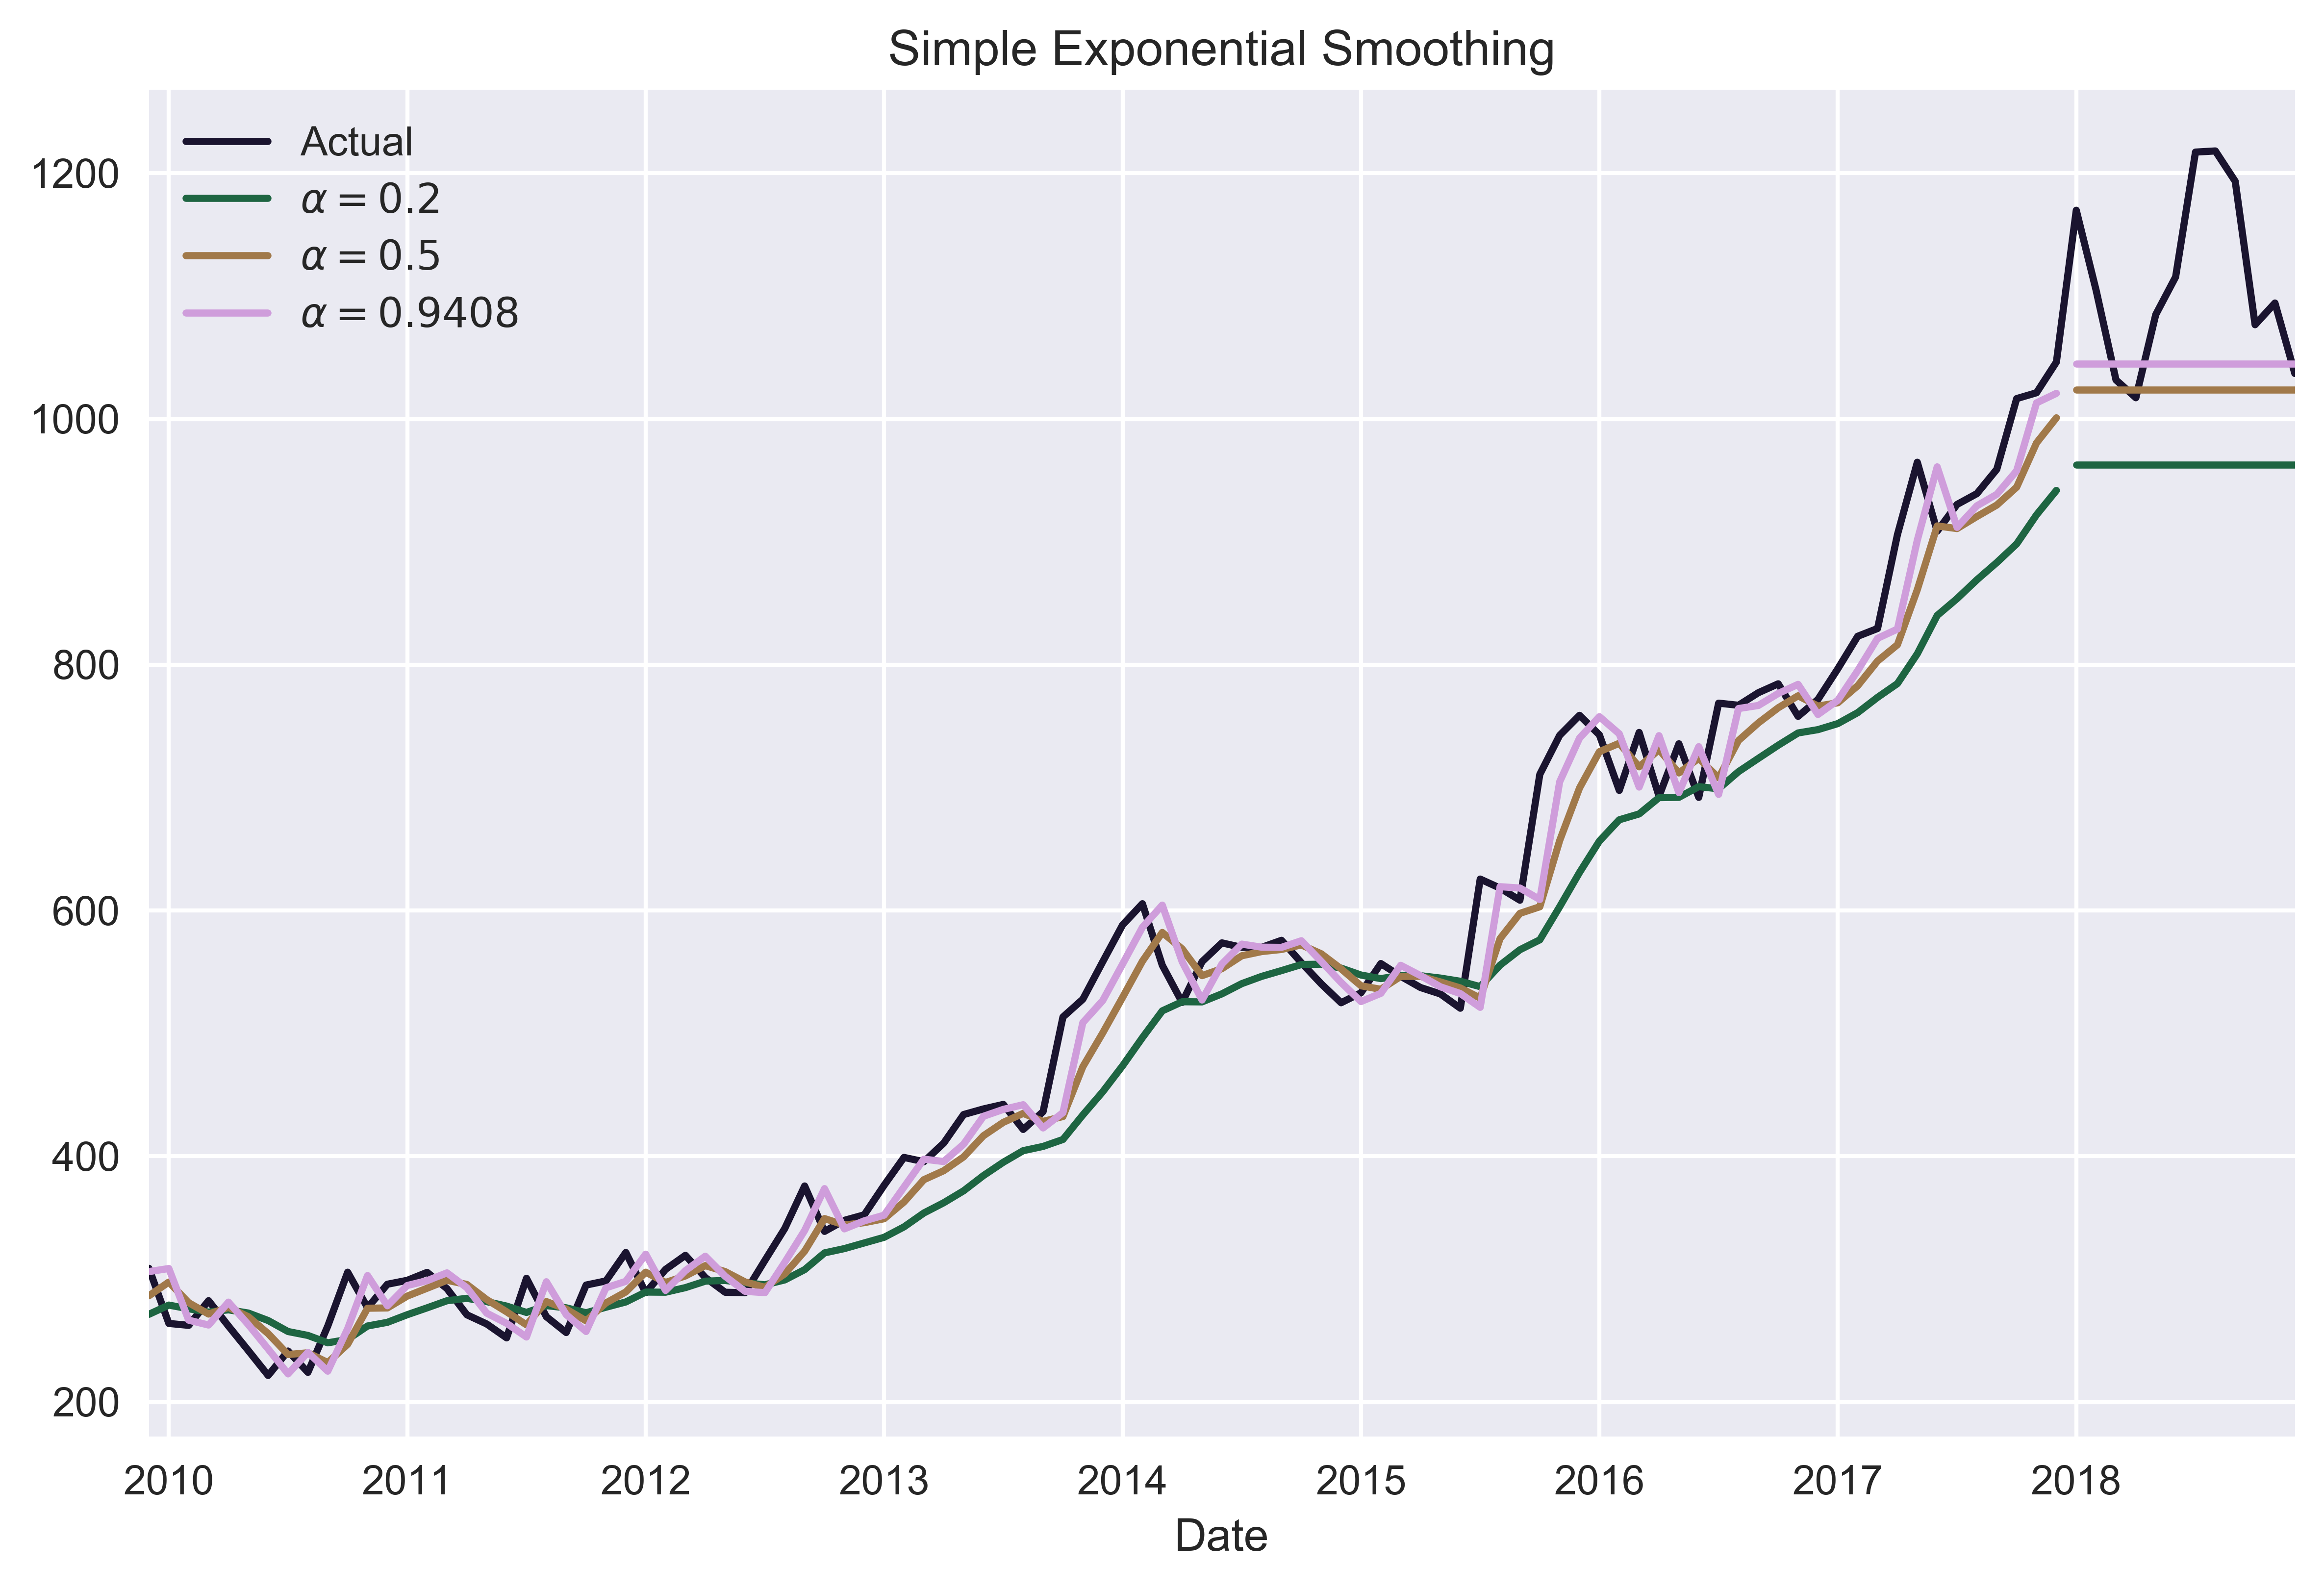

In [ ]:
goog.plot(color=COLORS[0], 
          title='Simple Exponential Smoothing',
          label='Actual',
          legend=True)

ses_forecast_1.plot(color=COLORS[1], legend=True, 
                    label=r'$\alpha=0.2$')
ses_1.fittedvalues.plot(color=COLORS[1])

ses_forecast_2.plot(color=COLORS[2], legend=True, 
                    label=r'$\alpha=0.5$')
ses_2.fittedvalues.plot(color=COLORS[2])

ses_forecast_3.plot(color=COLORS[3], legend=True, 
                    label=r'$\alpha={0:.4f}$'.format(alpha))
ses_3.fittedvalues.plot(color=COLORS[3])

plt.tight_layout()
#plt.savefig('images/ch3_im15.png')
plt.show()

8. Fit 3 variants of the Holt's Smoothing models and create forecasts:

In [ ]:
# Holt's model with linear trend
hs_1 = Holt(goog_train).fit()
hs_forecast_1 = hs_1.forecast(test_length)

# Holt's model with exponential trend
hs_2 = Holt(goog_train, exponential=True).fit()
# equivalent to ExponentialSmoothing(goog_train, trend='mul').fit()
hs_forecast_2 = hs_2.forecast(test_length)

# Holt's model with exponential trend and damping
hs_3 = Holt(goog_train, exponential=False, 
            damped=True).fit(damping_slope=0.99)
hs_forecast_3 = hs_3.forecast(test_length)

9. Plot the original prices together with the models' results:

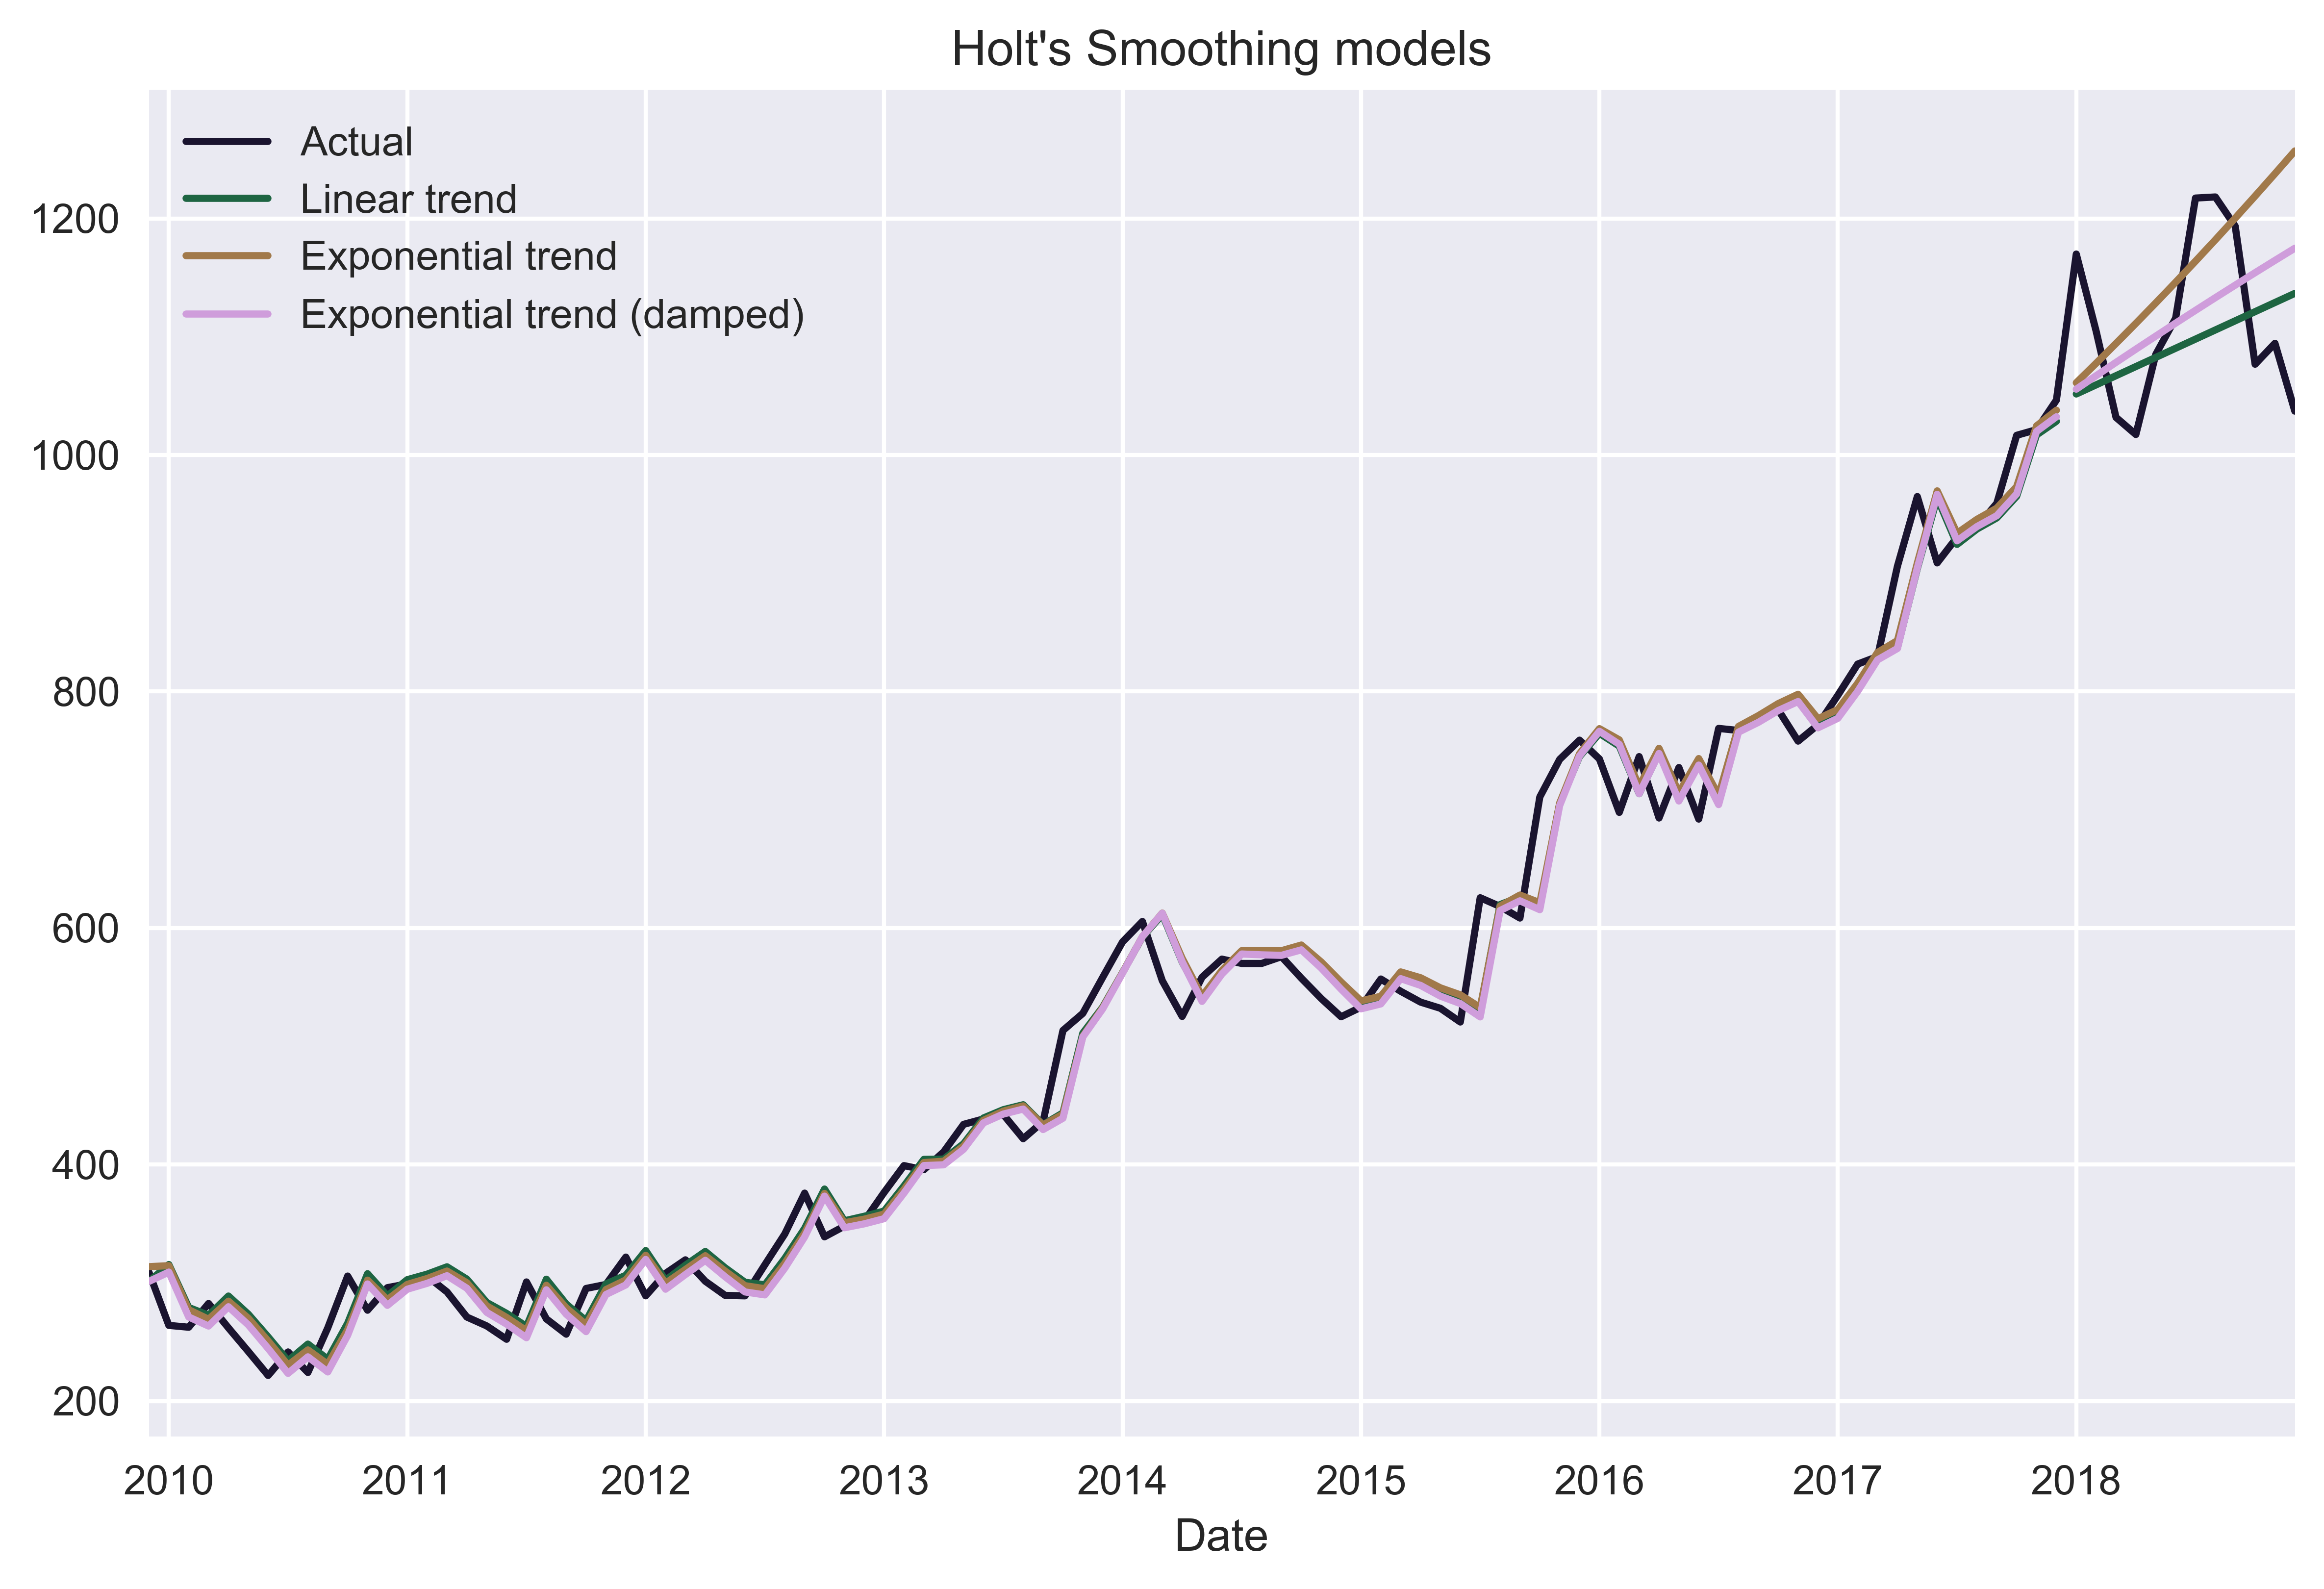

In [ ]:
goog.plot(color=COLORS[0],
          title="Holt's Smoothing models",
          label='Actual',
          legend=True)

hs_1.fittedvalues.plot(color=COLORS[1])
hs_forecast_1.plot(color=COLORS[1], legend=True, 
                   label='Linear trend')

hs_2.fittedvalues.plot(color=COLORS[2])
hs_forecast_2.plot(color=COLORS[2], legend=True, 
                   label='Exponential trend')

hs_3.fittedvalues.plot(color=COLORS[3])
hs_forecast_3.plot(color=COLORS[3], legend=True, 
                   label='Exponential trend (damped)')

plt.tight_layout()
#plt.savefig('images/ch3_im16.png')
plt.show()

### There's more...

In [ ]:
SEASONAL_PERIODS = 12

# Holt-Winter's model with exponential trend
hw_1 = ExponentialSmoothing(goog_train, 
                            trend='mul', 
                            seasonal='add', 
                            seasonal_periods=SEASONAL_PERIODS).fit()
hw_forecast_1 = hw_1.forecast(test_length)

# Holt-Winter's model with exponential trend and damping
hw_2 = ExponentialSmoothing(goog_train, 
                            trend='mul', 
                            seasonal='add', 
                            seasonal_periods=SEASONAL_PERIODS, 
                            damped=True).fit()
hw_forecast_2 = hw_2.forecast(test_length)

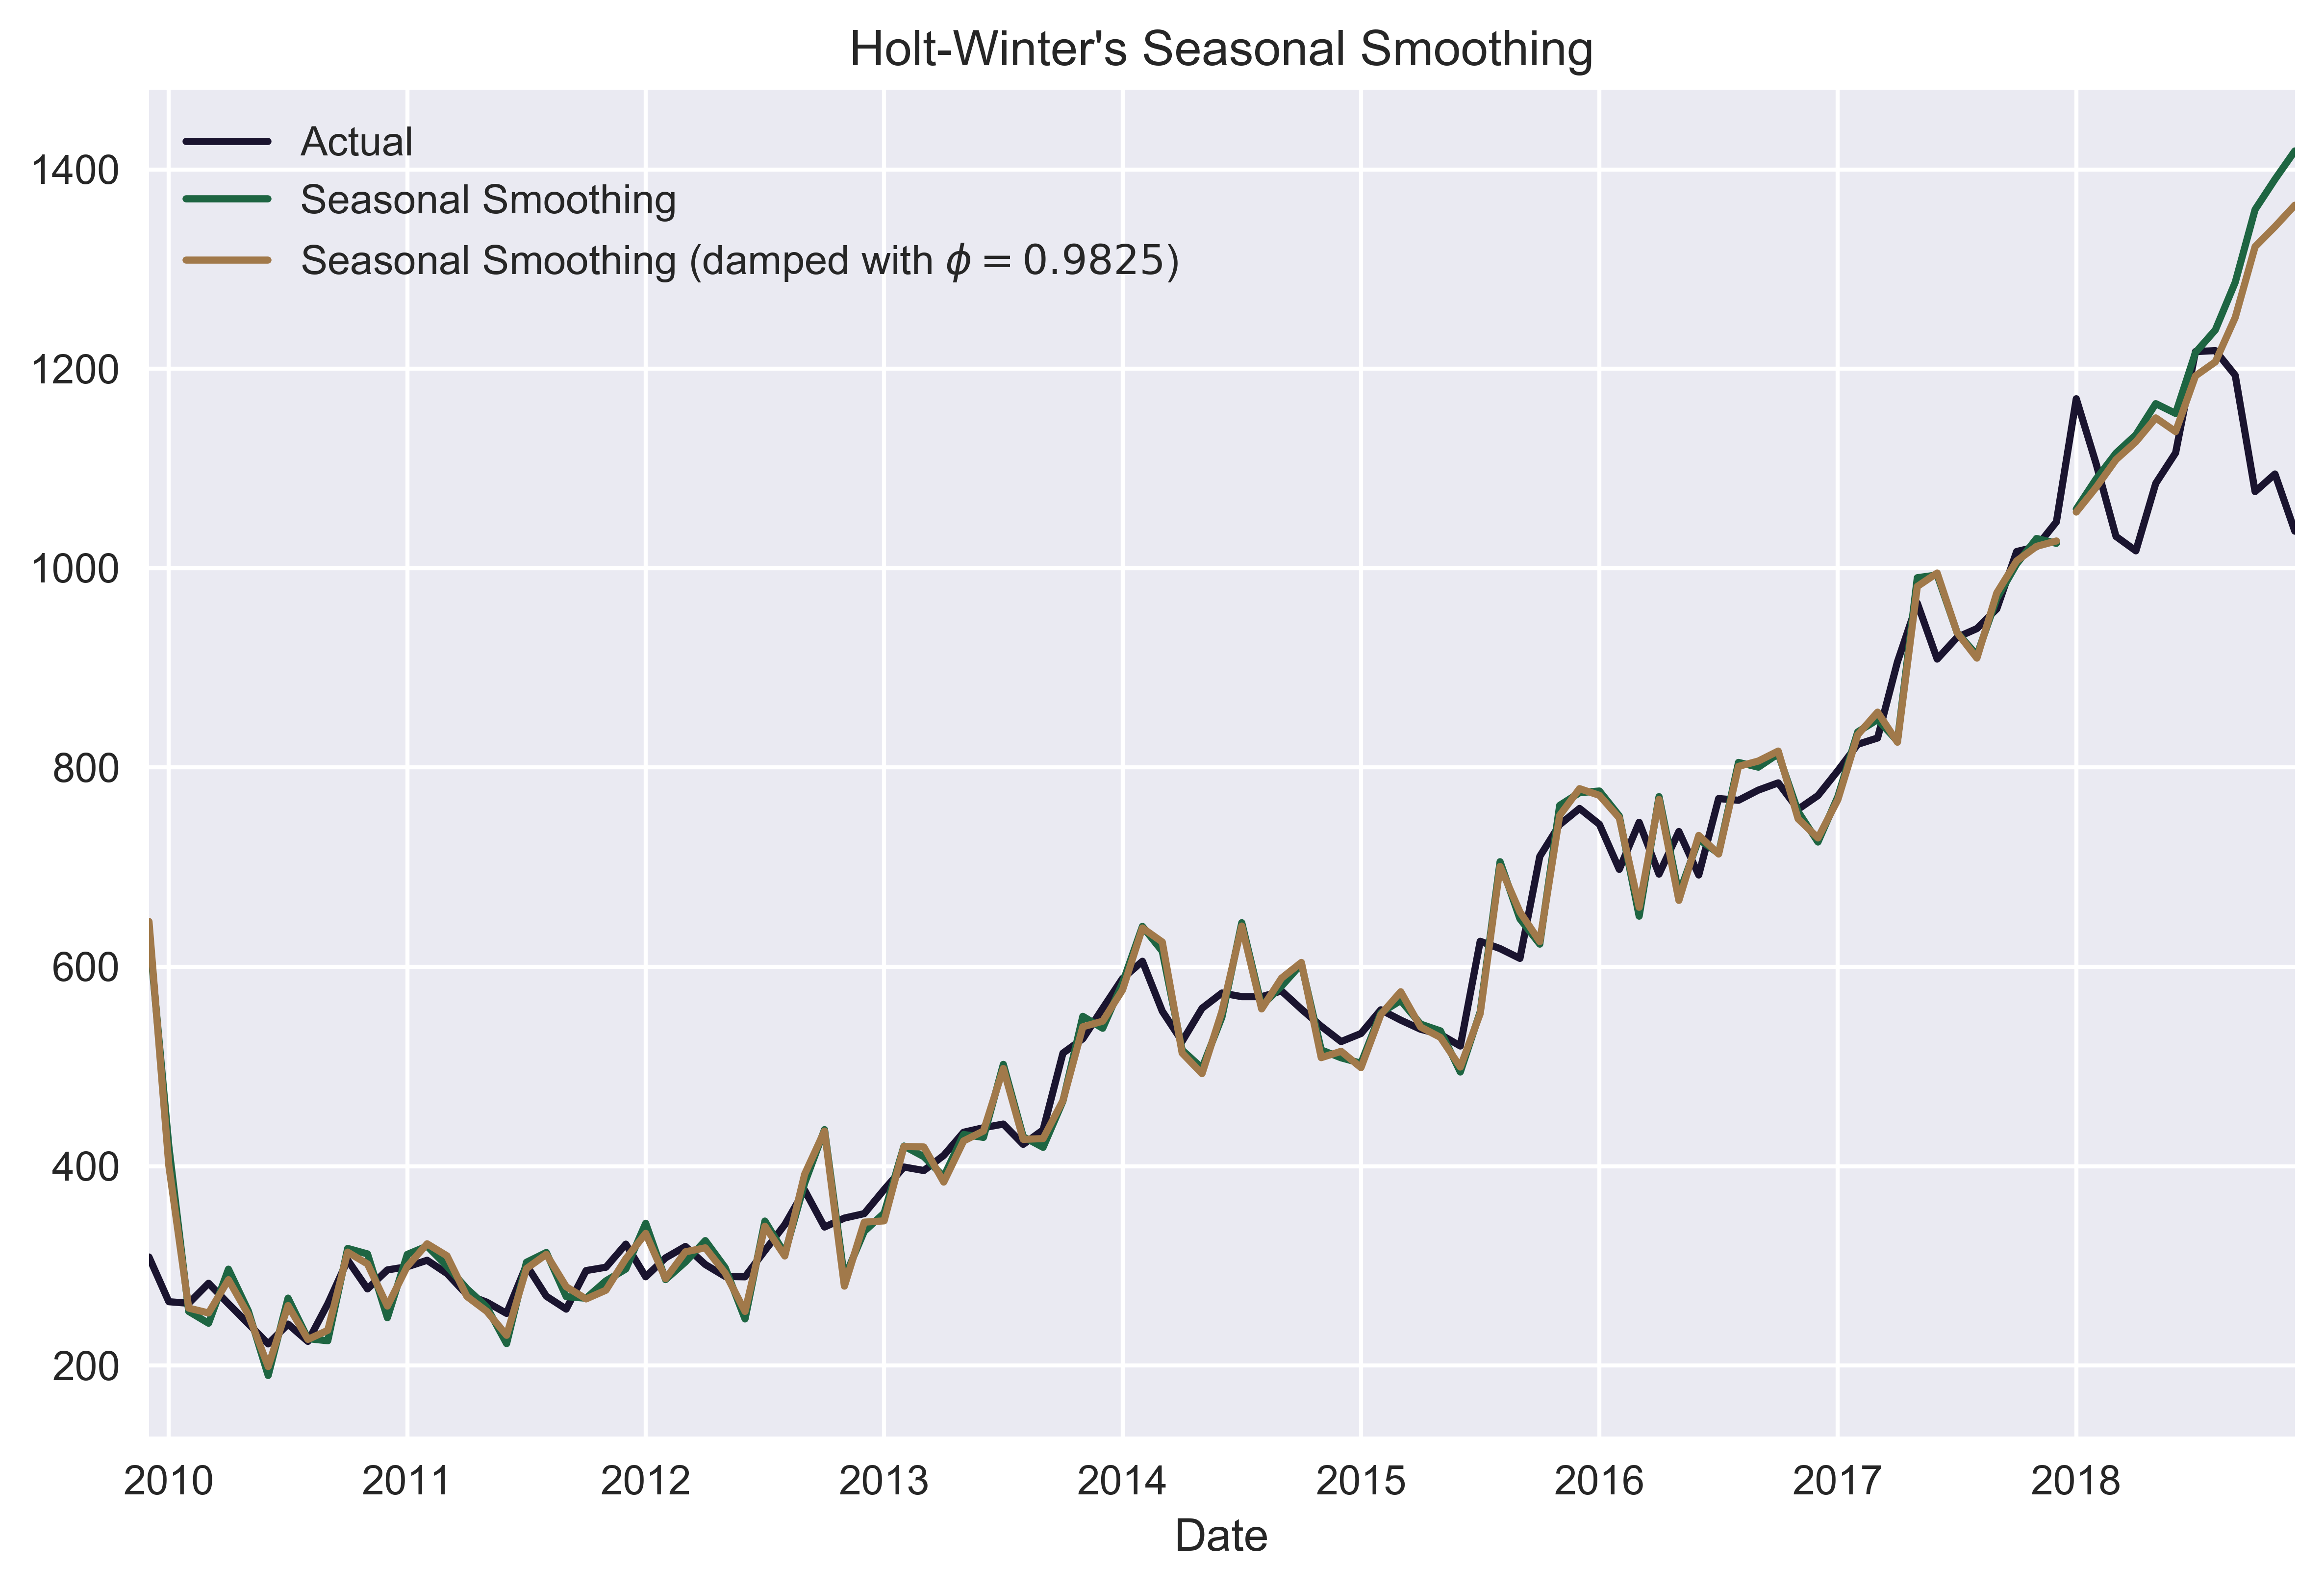

In [ ]:
goog.plot(color=COLORS[0],
          title="Holt-Winter's Seasonal Smoothing",
          label='Actual',
          legend=True)

hw_1.fittedvalues.plot(color=COLORS[1])
hw_forecast_1.plot(color=COLORS[1], legend=True, 
                   label='Seasonal Smoothing')

phi = hw_2.model.params['damping_slope']
plot_label = f'Seasonal Smoothing (damped with $\phi={phi:.4f}$)'

hw_2.fittedvalues.plot(color=COLORS[2])
hw_forecast_2.plot(color=COLORS[2], legend=True, 
                   label=plot_label)

plt.tight_layout()
#plt.savefig('images/ch3_im17.png')
plt.show()

## Modeling time series with ARIMA class models

### How to do it...

1. Import the libraries:

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs
from chapter_3_utils import test_autocorrelation

2. Download Google's stock prices and resample to weekly frequency:

In [ ]:
df = yf.download('GOOG',
                 start='2015-01-01',
                 end='2018-12-31',
                 adjusted=True,
                 progress=False)

goog = df.resample('W') \
         .last() \
         .rename(columns={'Adj Close': 'adj_close'}) \
         .adj_close 

3. Apply the first differences to the price series and plot them together:

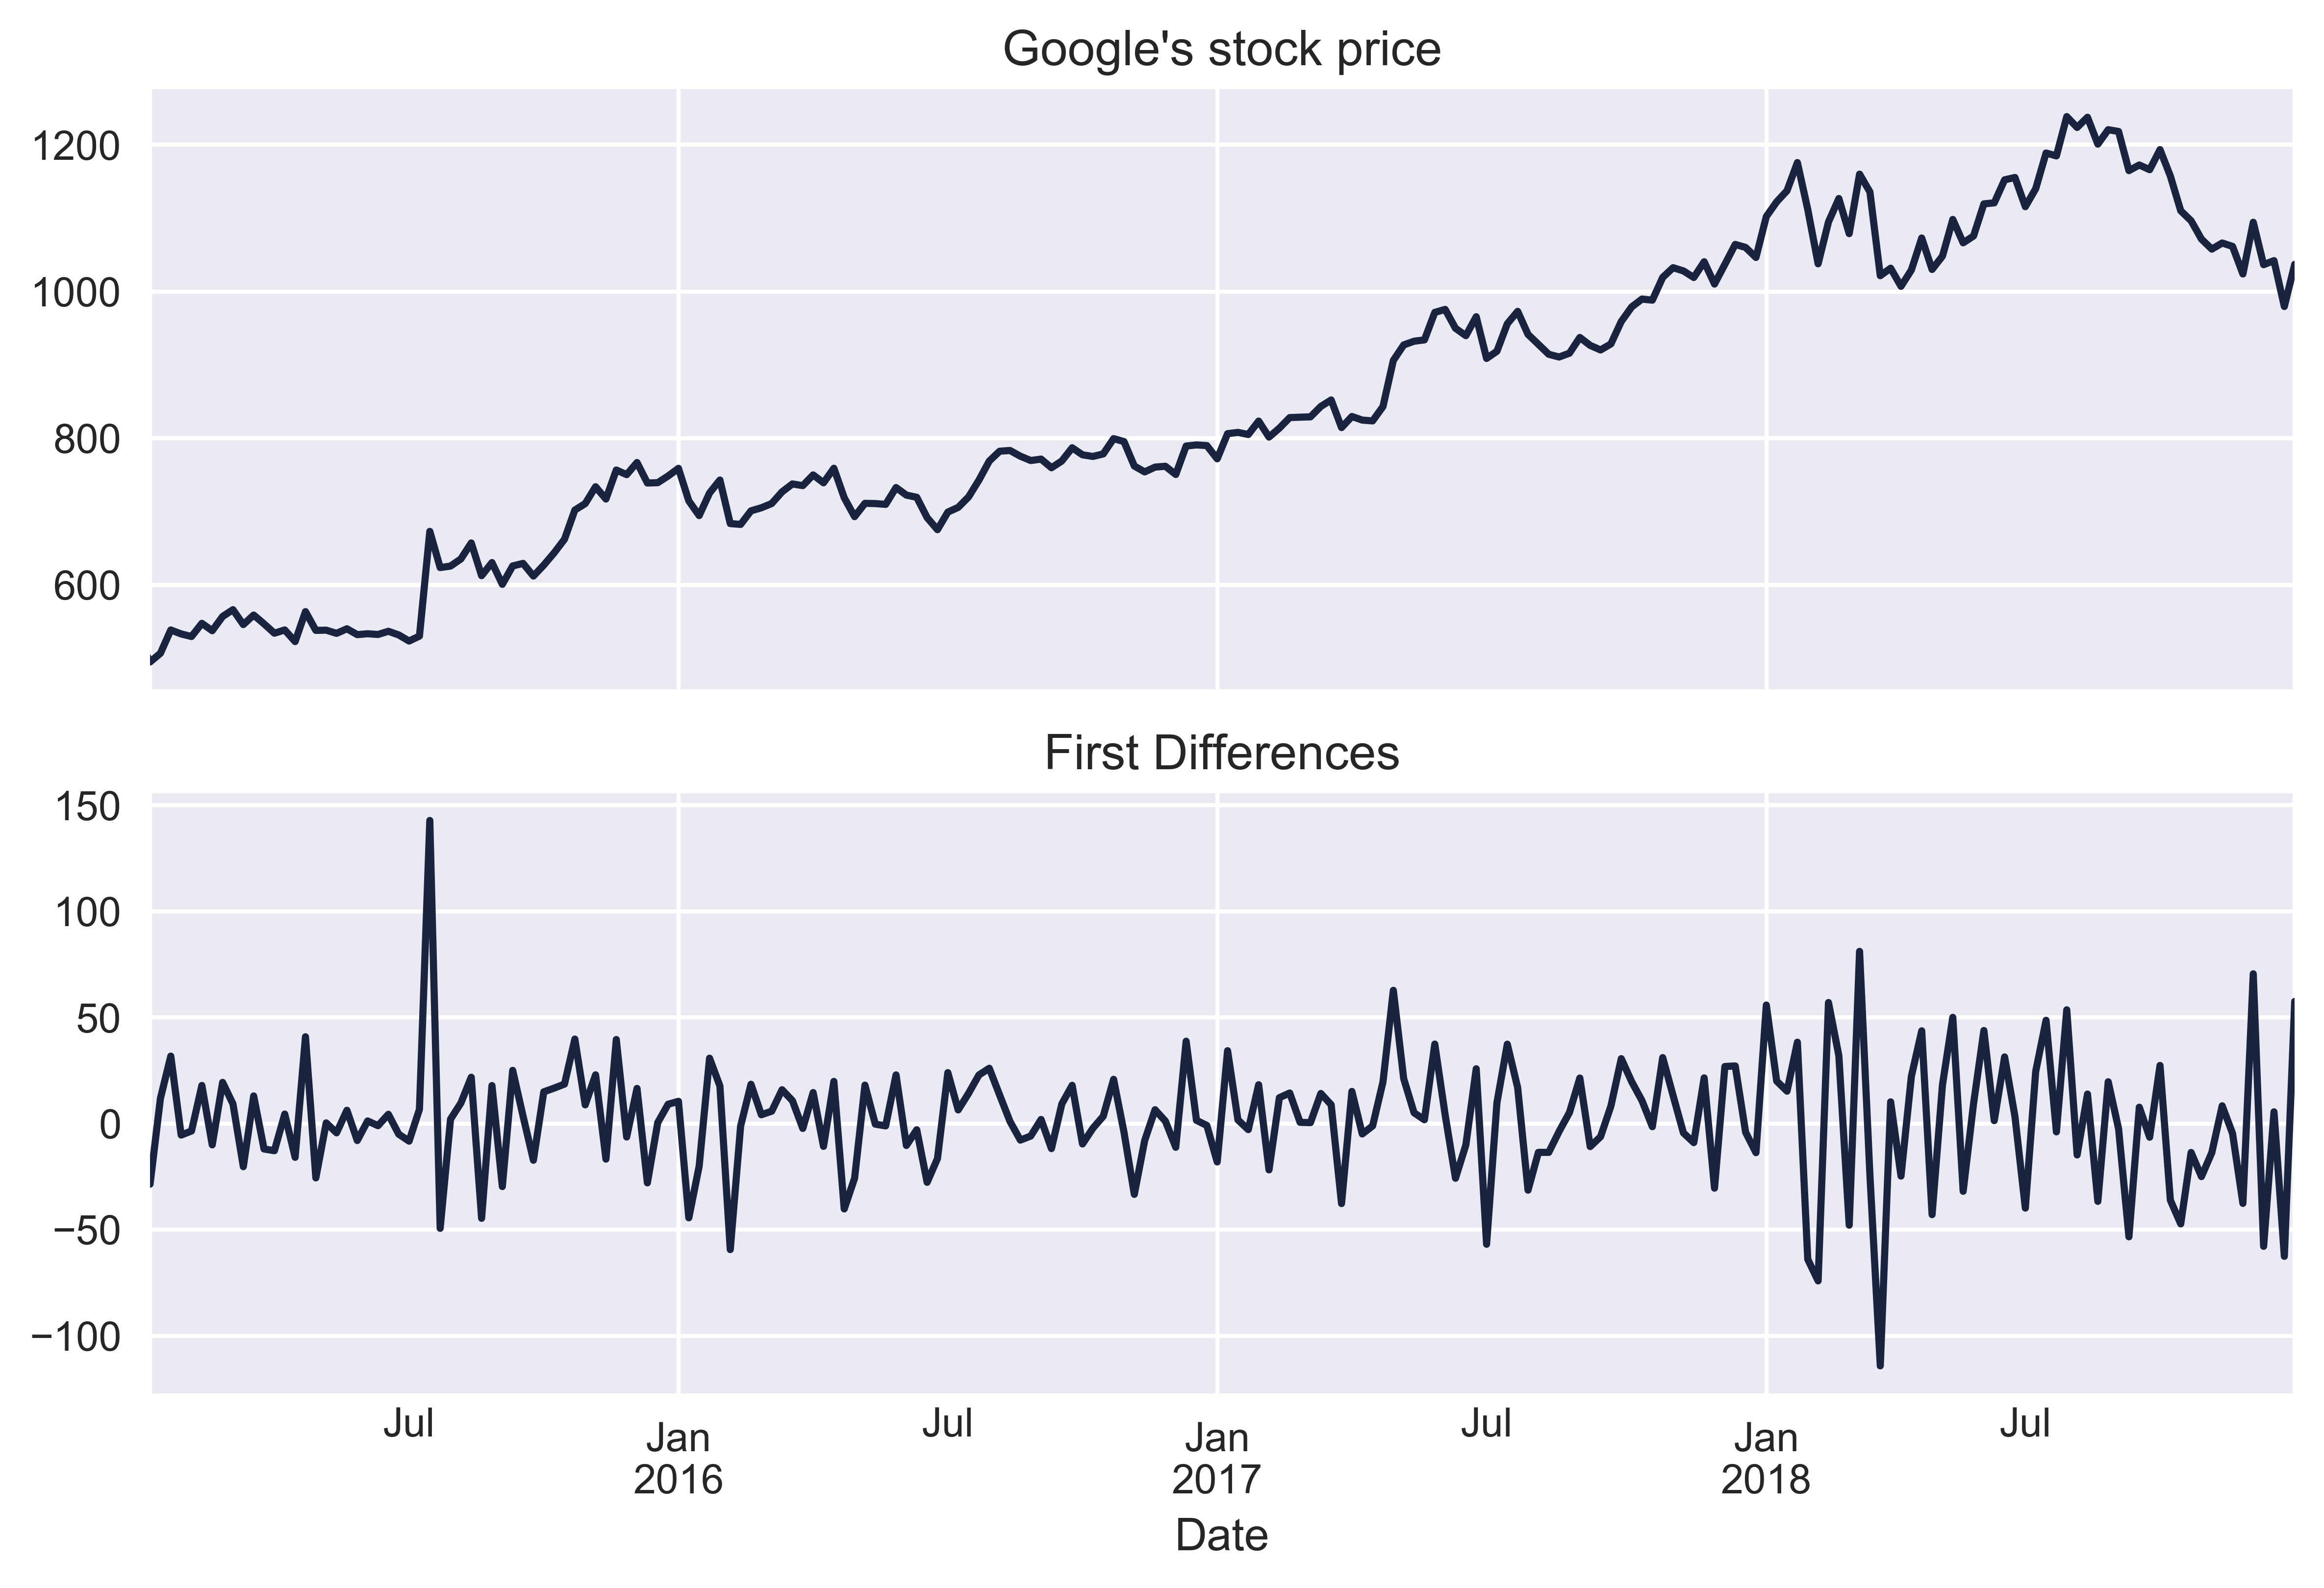

In [ ]:
goog_diff = goog.diff().dropna()

fig, ax = plt.subplots(2, sharex=True)
goog.plot(title = "Google's stock price", ax=ax[0])
goog_diff.plot(ax=ax[1], title='First Differences')

plt.tight_layout()
#plt.savefig('images/ch3_im18.png')
plt.show()

4. Test the differenced series for stationarity:

ADF test statistic: -12.79 (p-val: 0.00)
KPSS test statistic: 0.11 (p-val: 0.10)


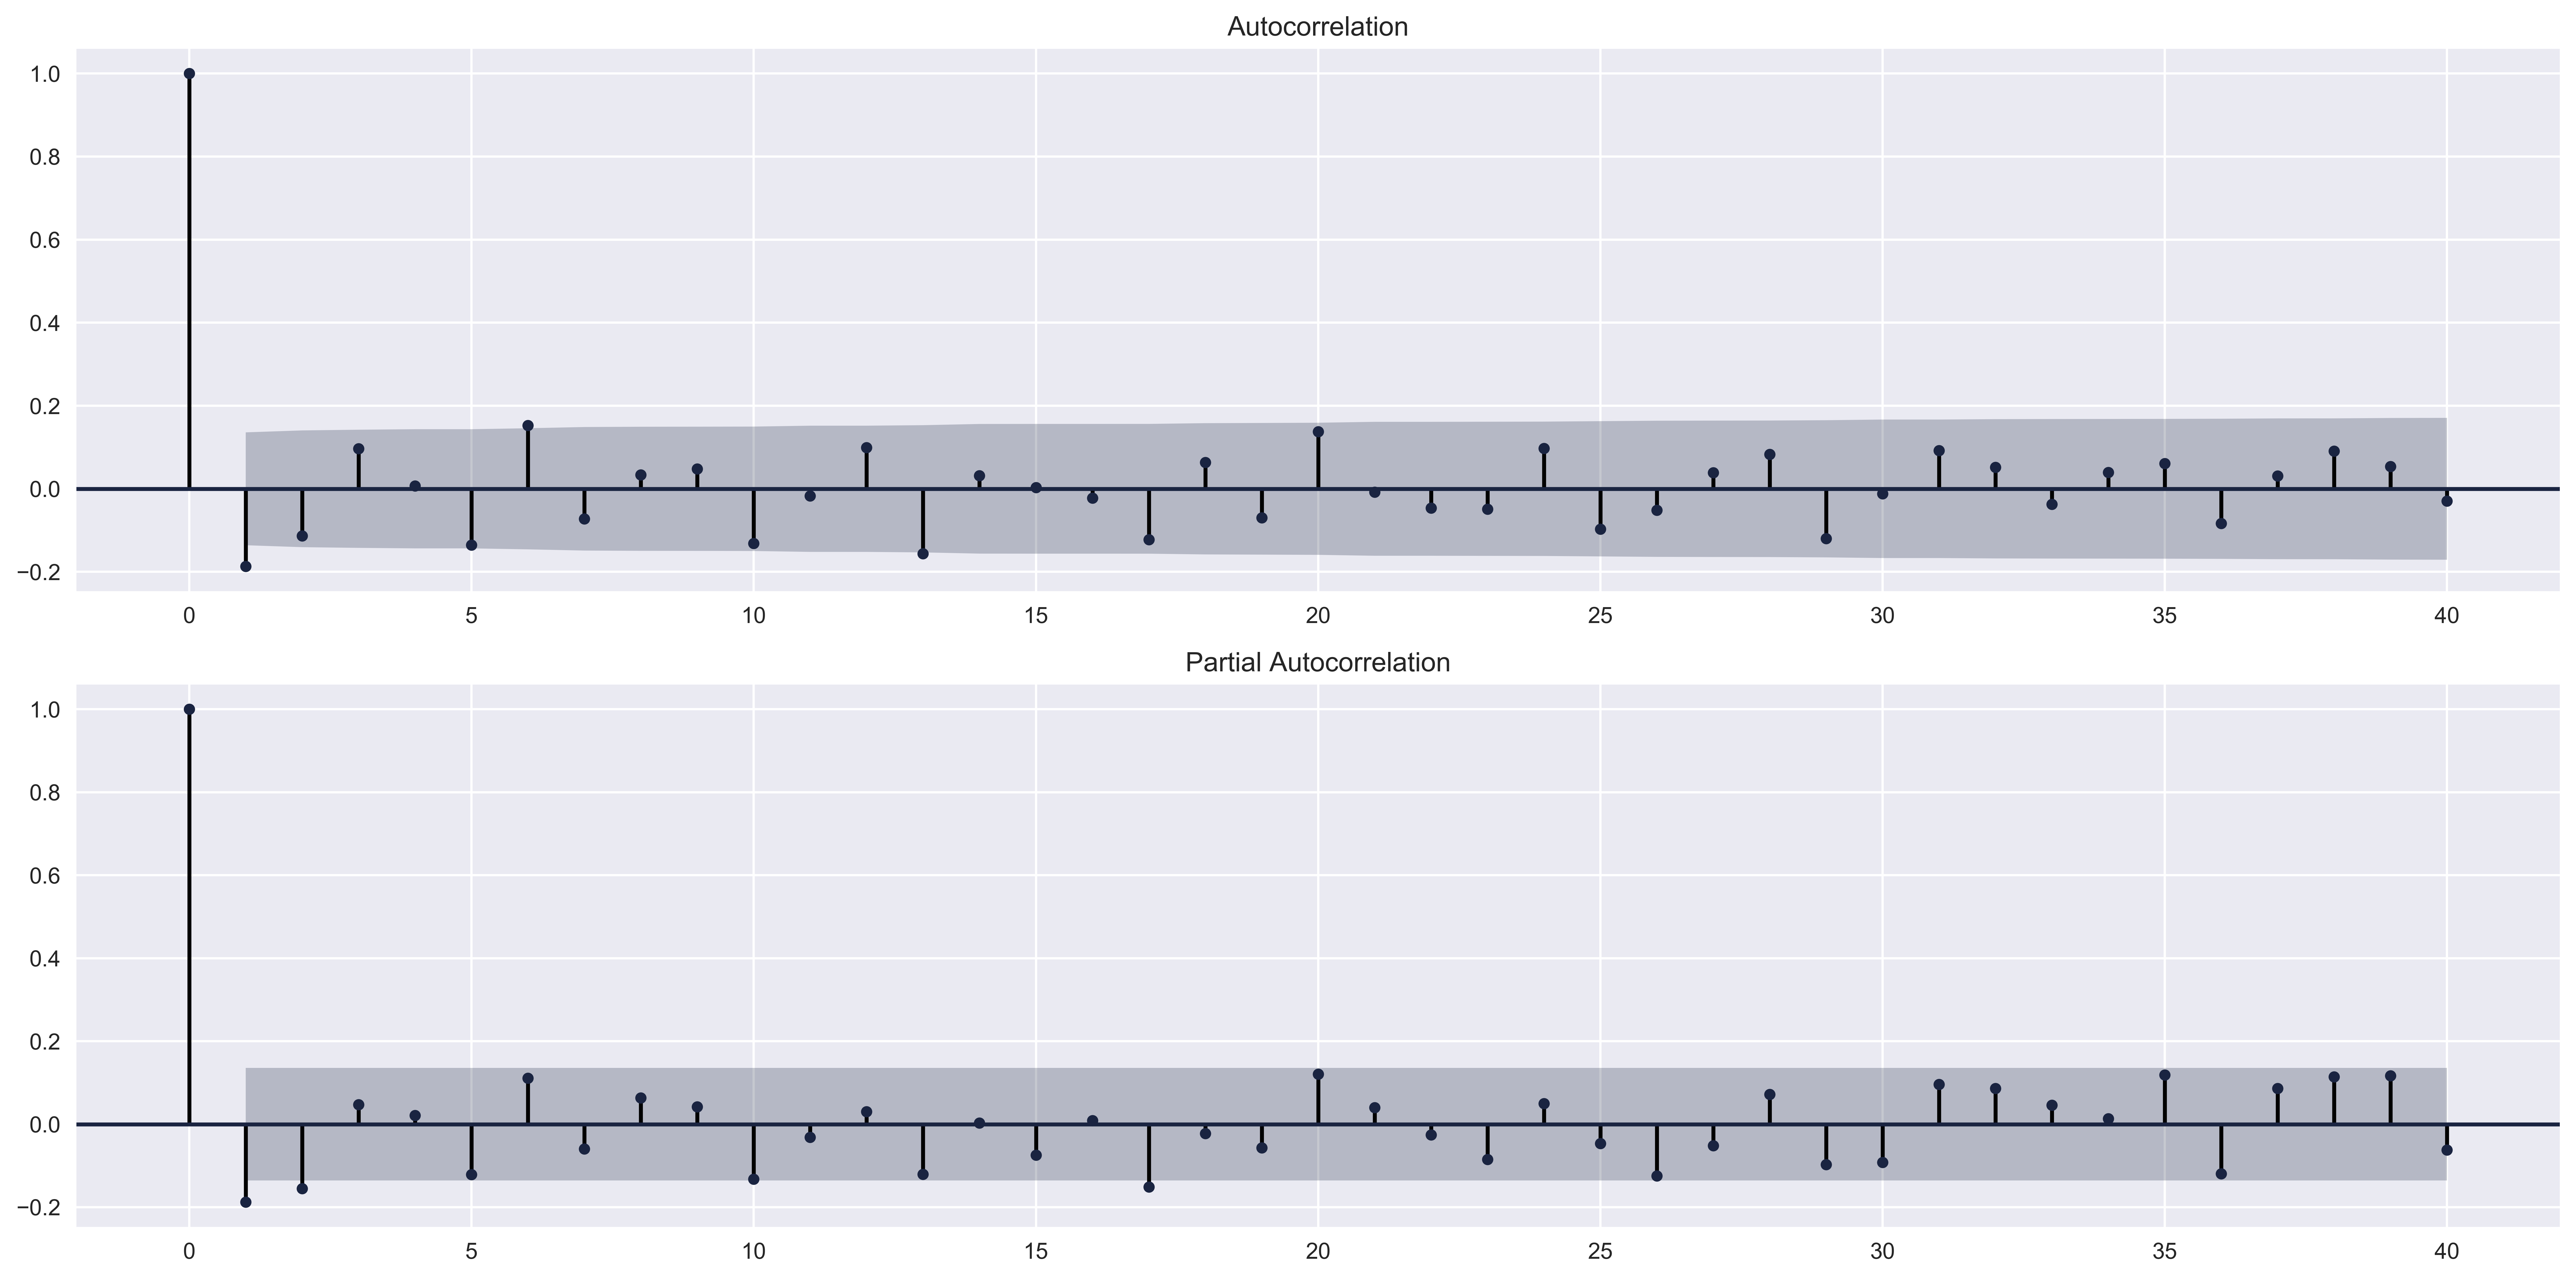

In [ ]:
fig = test_autocorrelation(goog_diff)

plt.tight_layout()
#plt.savefig('images/ch3_im19.png')
plt.show()

5. Based on the results of the tests, specify the ARIMA model and fit it to the data:

In [ ]:
arima = ARIMA(goog, order=(2, 1, 1)).fit(disp=0)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.adj_close   No. Observations:                  208
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -987.233
Method:                       css-mle   S.D. of innovations             27.859
Date:                Fri, 24 Jan 2020   AIC                           1984.466
Time:                        23:47:31   BIC                           2001.154
Sample:                    01-11-2015   HQIC                          1991.214
                         - 12-30-2018                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.4700      1.441      1.714      0.088      -0.354       5.294
ar.L1.D.adj_close    -0.3908      0.280     -1.398      0.164      -0.939       0.157
ar.L2.D.adj_close    -0.1910      0.082     -2.322      0.021      -0.352      -0.030
ma.L1.D.adj_close     0.1781      0.280      0.637      0.525      -0.370       0.726
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0233           -2.0467j            2.2883           -0.3238
AR.2           -1.0233           +2.0467j            2.2883            0.3238
MA.1           -5.6163           +0.0000j            5.6163            0.5000
-----------------------------------------------------------------------------
"""

6. Prepare a function for diagnosing the fit of the model based on its residuals:

In [ ]:
def arima_diagnostics(resids, n_lags=40):
    '''
    Function for diagnosing the fit of an ARIMA model by investigating the residuals.
    
    Parameters
    ----------
    resids : np.array
        An array containing the residuals of a fitted model
    n_lags : int
        Number of lags for autocorrelation plot
        
    Returns
    -------
    fig : matplotlib.figure.Figure
        Created figure
    '''
     
    # create placeholder subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

    r = resids
    resids = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids[~(np.isnan(resids))]
    
    # residuals over time
    sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
    ax1.set_title('Standardized residuals')

    # distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    
    sns.distplot(resids_nonmissing, hist=True, kde=True, 
                 norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
    ax2.set_title('Distribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
        
    # Q-Q plot
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ax3.set_title('Q-Q plot')

    # ACF plot
    plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
    ax4.set_title('ACF plot')

    return fig

7. Test the residuals of the fitted ARIMA model:

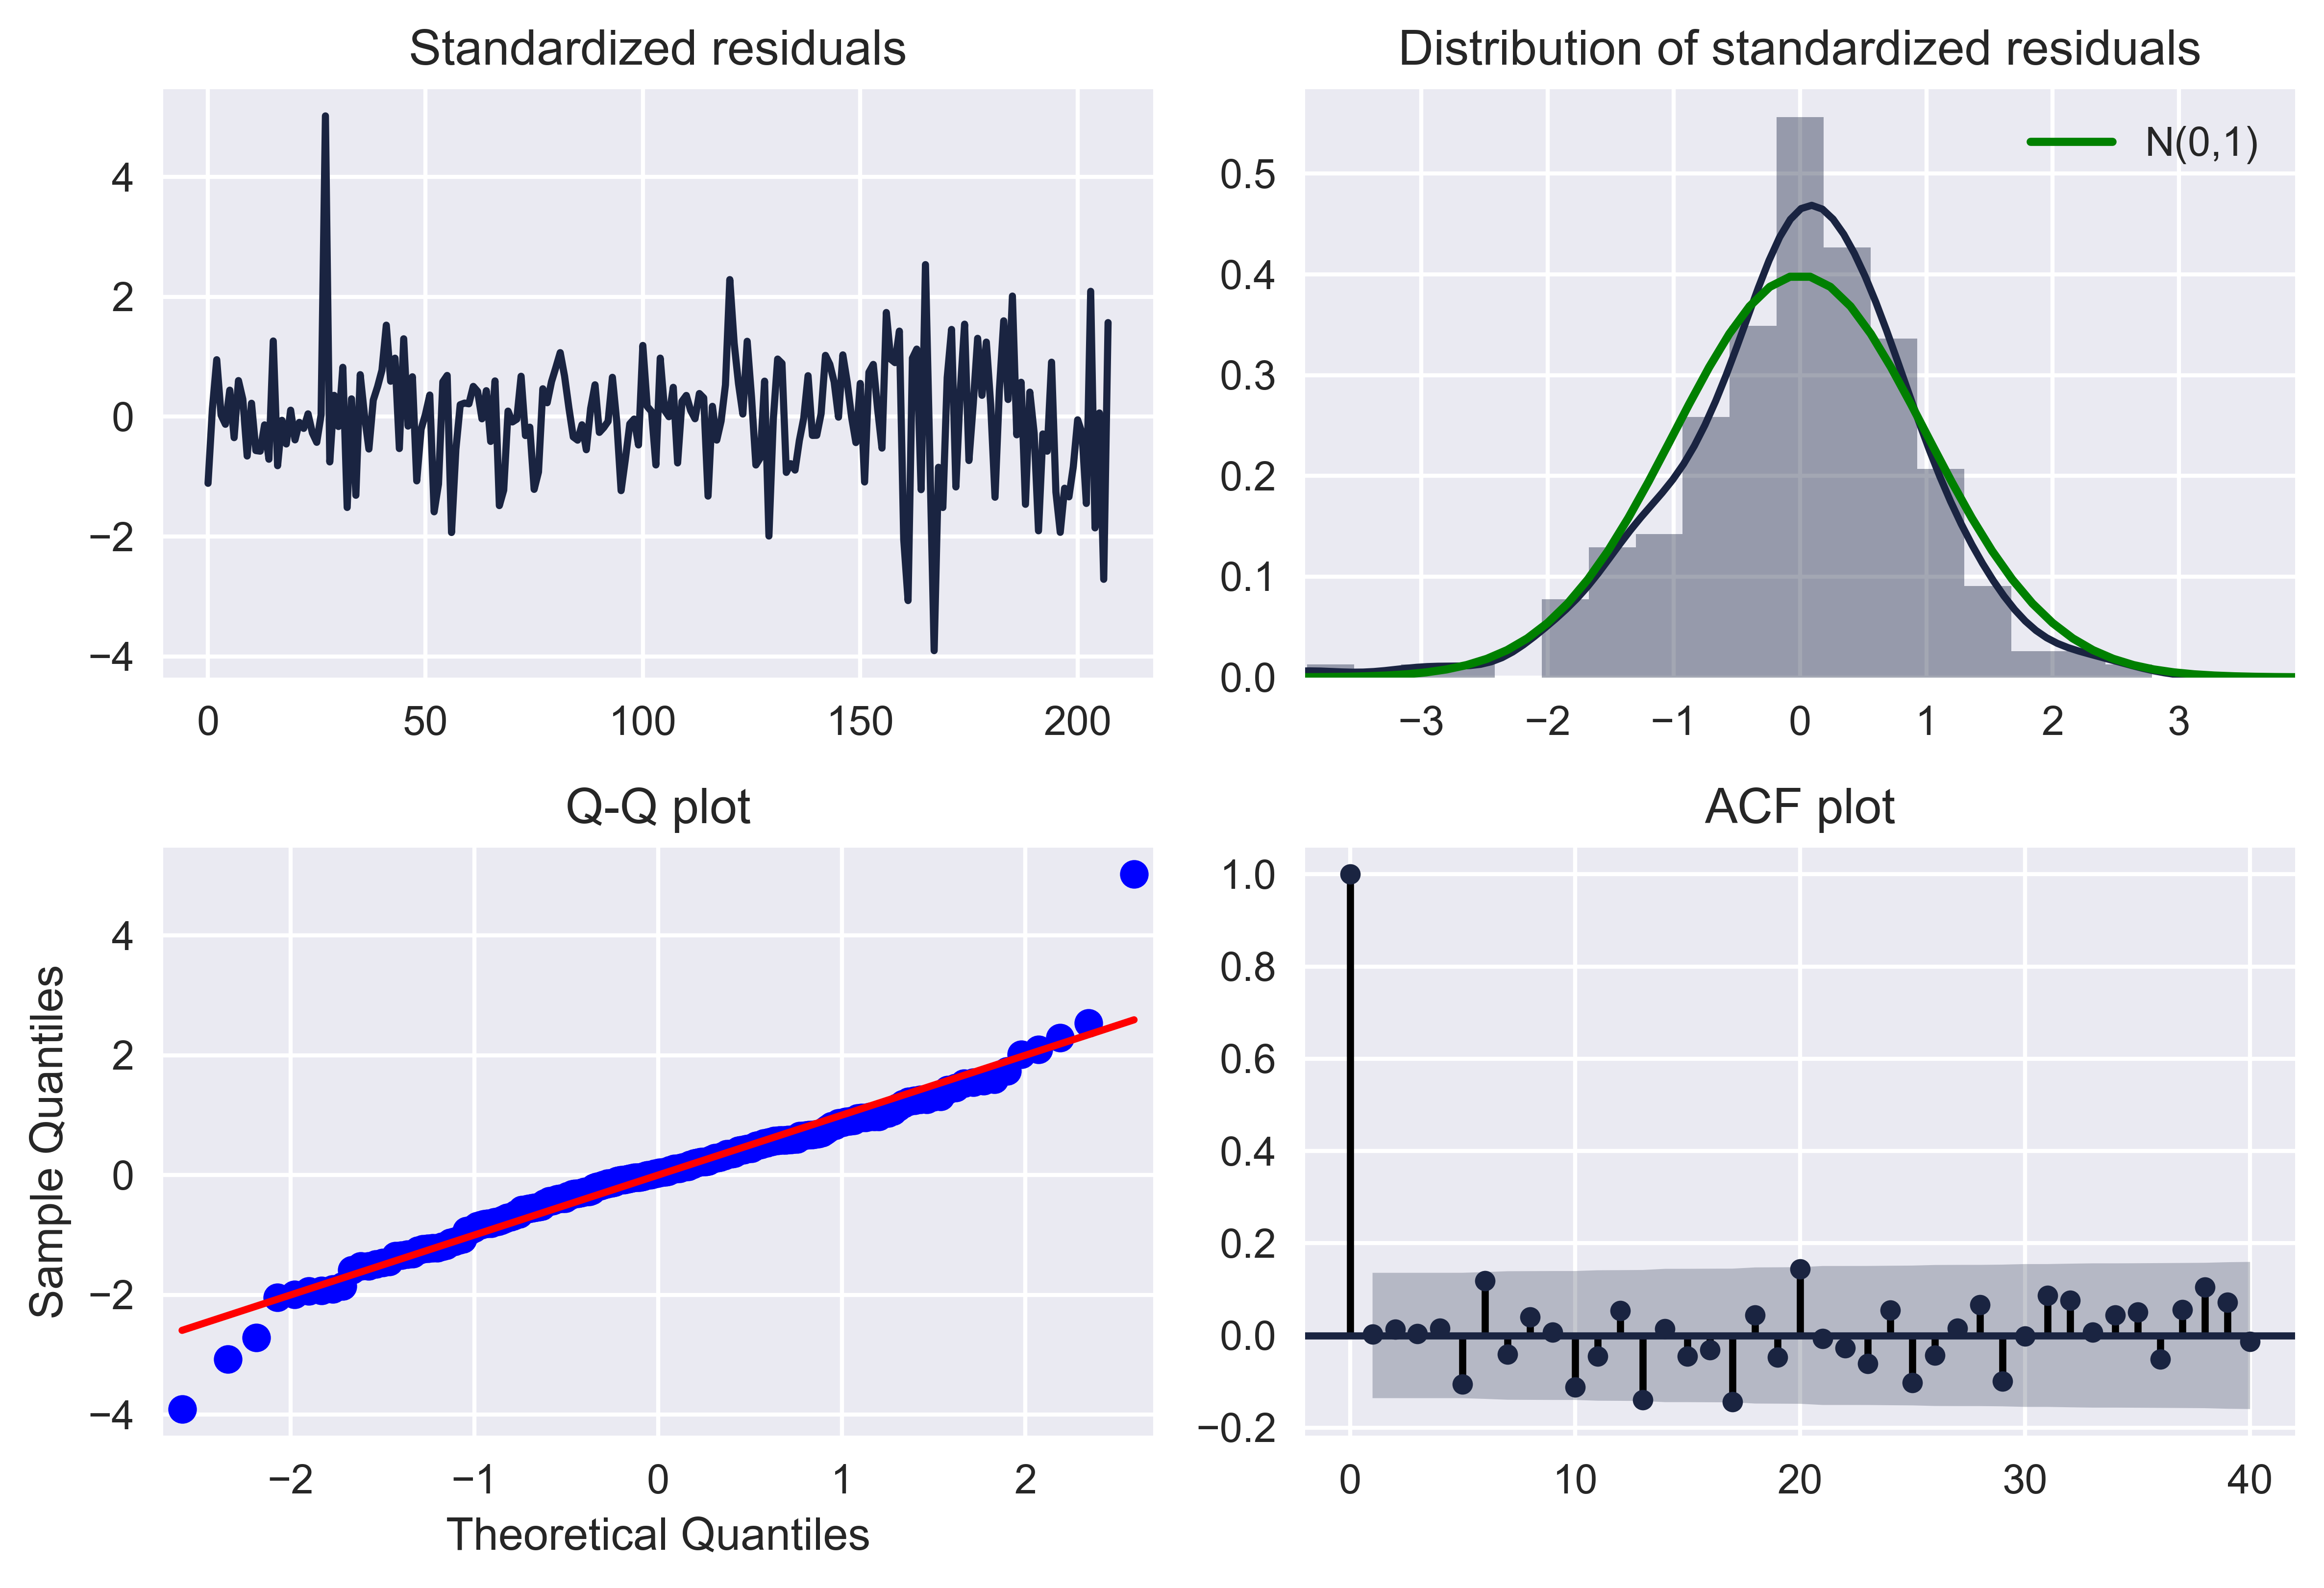

In [ ]:
arima_diagnostics(arima.resid, 40)

plt.tight_layout()
#plt.savefig('images/ch3_im21.png')
plt.show()

8. Apply the Ljung-Box's test for no autocorrelation in the residuals and plot the results:

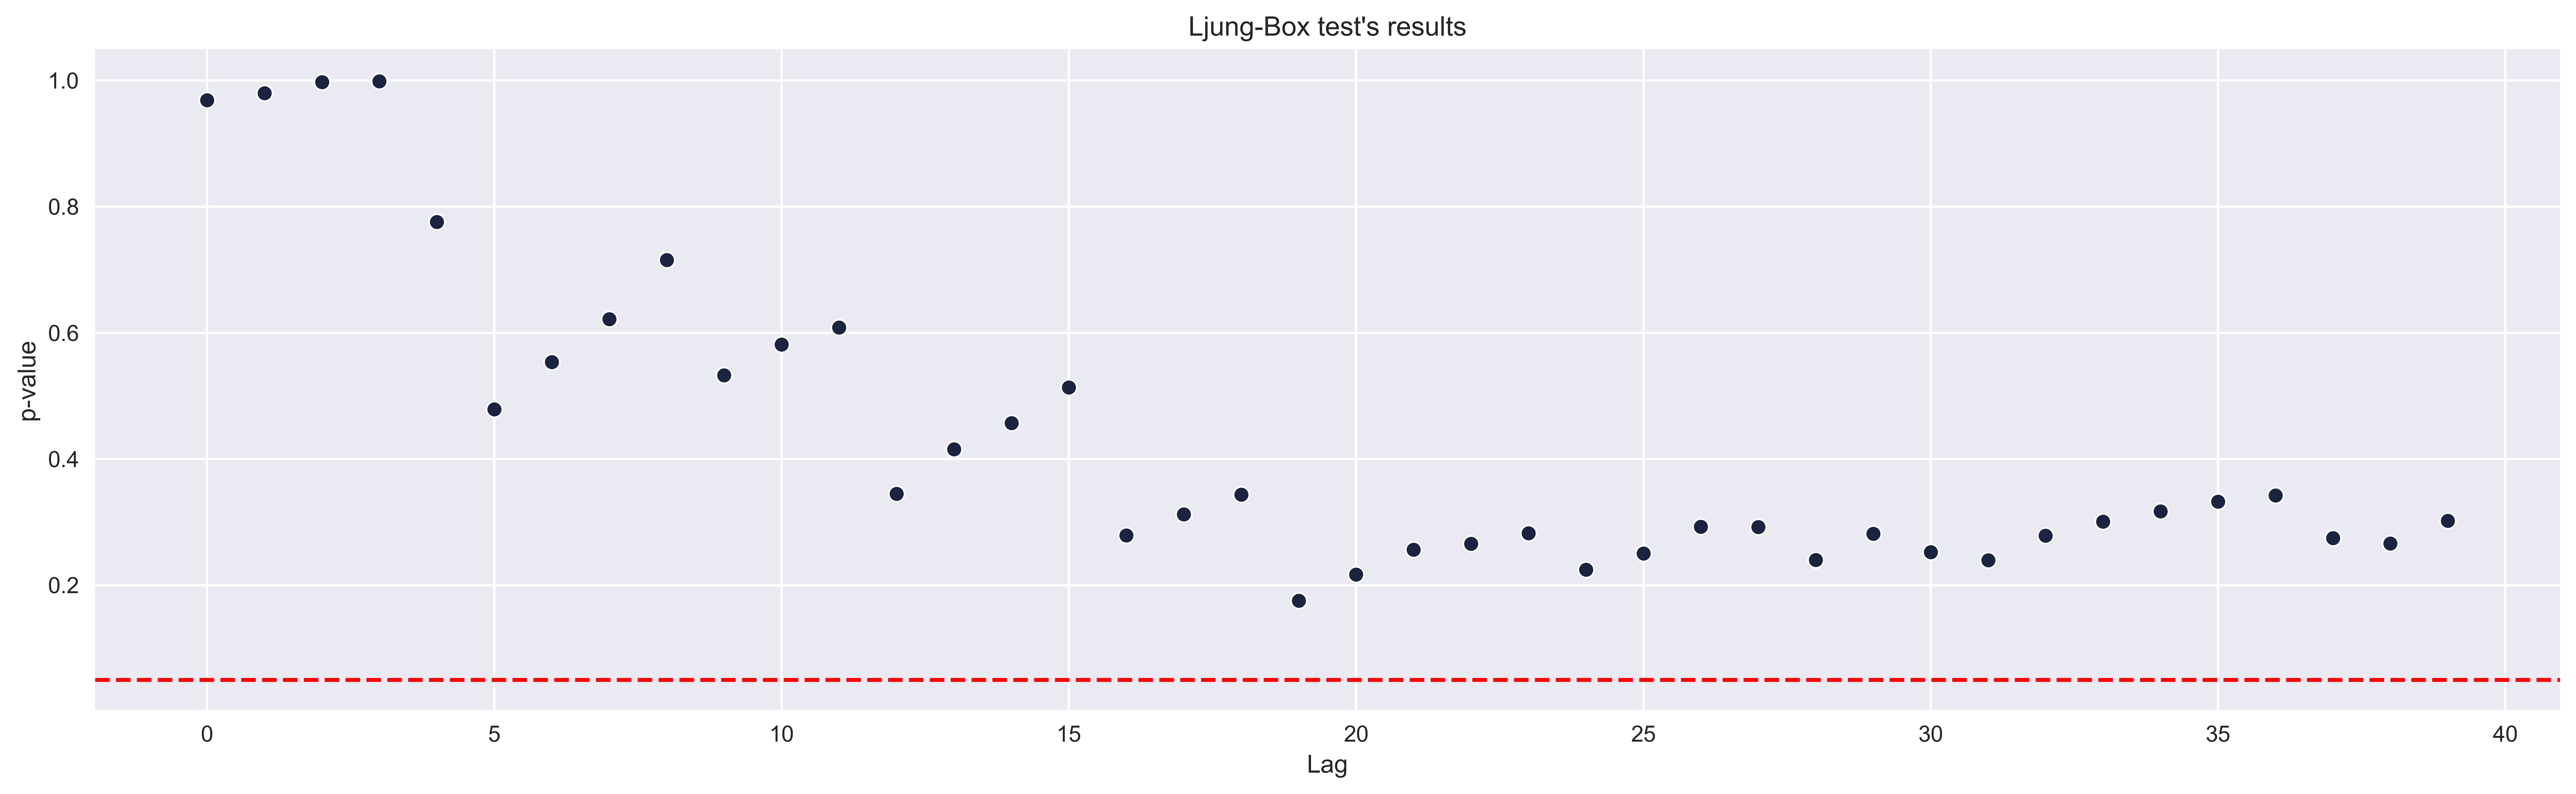

In [ ]:
ljung_box_results = acorr_ljungbox(arima.resid)

fig, ax = plt.subplots(1, figsize=[16, 5])
sns.scatterplot(x=range(len(ljung_box_results[1])), 
                y=ljung_box_results[1], 
                ax=ax)
ax.axhline(0.05, ls='--', c='r')
ax.set(title="Ljung-Box test's results",
       xlabel='Lag',
       ylabel='p-value')

plt.tight_layout()
#plt.savefig('images/ch3_im22.png')
plt.show()

### There's more

1. We start by importing the library:

In [ ]:
import pmdarima as pm

2. We run `auto_arima` with the majority of settings set to default values. We only exclude potential seasonality.

In [ ]:
auto_arima = pm.auto_arima(goog, 
                           error_action='ignore',
                           suppress_warnings=True,
                           seasonal=False)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  208
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -988.749
Method:                       css-mle   S.D. of innovations             28.065
Date:                Fri, 24 Jan 2020   AIC                           1983.497
Time:                        23:59:16   BIC                           1993.510
Sample:                             1   HQIC                          1987.546
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4561      1.486      1.653      0.100      -0.456       5.368
ma.L1.D.y     -0.2376      0.071     -3.339      0.001      -0.377      -0.098
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            4.2096           +0.0000j            4.2096            0.0000
-----------------------------------------------------------------------------
"""

3. In the next step we try to tune the search of the optimal parameters:

In [ ]:
auto_arima = pm.auto_arima(goog,
                           error_action='ignore',
                           suppress_warnings=True,
                           seasonal=False,
                           stepwise=False,
                           approximation=False,
                           n_jobs=-1)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  208
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -982.698
Method:                       css-mle   S.D. of innovations             27.235
Date:                Fri, 24 Jan 2020   AIC                           1979.397
Time:                        23:59:29   BIC                           2002.759
Sample:                             1   HQIC                          1988.843
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4675      1.478      1.670      0.096      -0.429       5.364
ar.L1.D.y     -1.5445      0.124    -12.445      0.000      -1.788      -1.301
ar.L2.D.y     -1.1844      0.132     -8.982      0.000      -1.443      -0.926
ar.L3.D.y     -0.3043      0.072     -4.230      0.000      -0.445      -0.163
ma.L1.D.y      1.3587      0.116     11.731      0.000       1.132       1.586
ma.L2.D.y      0.7929      0.119      6.655      0.000       0.559       1.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7904           -0.8927j            1.1924           -0.3653
AR.2           -0.7904           +0.8927j            1.1924            0.3653
AR.3           -2.3116           -0.0000j            2.3116           -0.5000
MA.1           -0.8567           -0.7261j            1.1230           -0.3881
MA.2           -0.8567           +0.7261j            1.1230            0.3881
-----------------------------------------------------------------------------
"""

## Forecasting using ARIMA class models

### How to do it...

1. Download additional test data and resample to weekly:

In [ ]:
df = yf.download('GOOG',
                 start='2019-01-01',
                 end='2019-03-31',
                 adjusted=True,
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

test = df.resample('W') \
         .last() \
         .rename(columns={'Adj Close': 'adj_close'}) \
         .adj_close 

Downloaded 62 rows of data.


2. Obtain forecasts from the first model and store them in a DataFrame:

In [ ]:
n_forecasts = len(test)

arima_pred = arima.forecast(n_forecasts)

arima_pred = [pd.DataFrame(arima_pred[0], columns=['prediction']),
              pd.DataFrame(arima_pred[2], columns=['ci_lower', 
                                                   'ci_upper'])]
arima_pred = pd.concat(arima_pred, axis=1).set_index(test.index)

3. Obtain forecasts from the second model and store them in a DataFrame:

In [ ]:
auto_arima_pred = auto_arima.predict(n_periods=n_forecasts, 
                                     return_conf_int=True, 
                                     alpha=0.05)

auto_arima_pred = [pd.DataFrame(auto_arima_pred[0], 
                                columns=['prediction']),
                   pd.DataFrame(auto_arima_pred[1], 
                                columns=['ci_lower', 'ci_upper'])]
auto_arima_pred = pd.concat(auto_arima_pred, 
                            axis=1).set_index(test.index)

4. Plot the results:

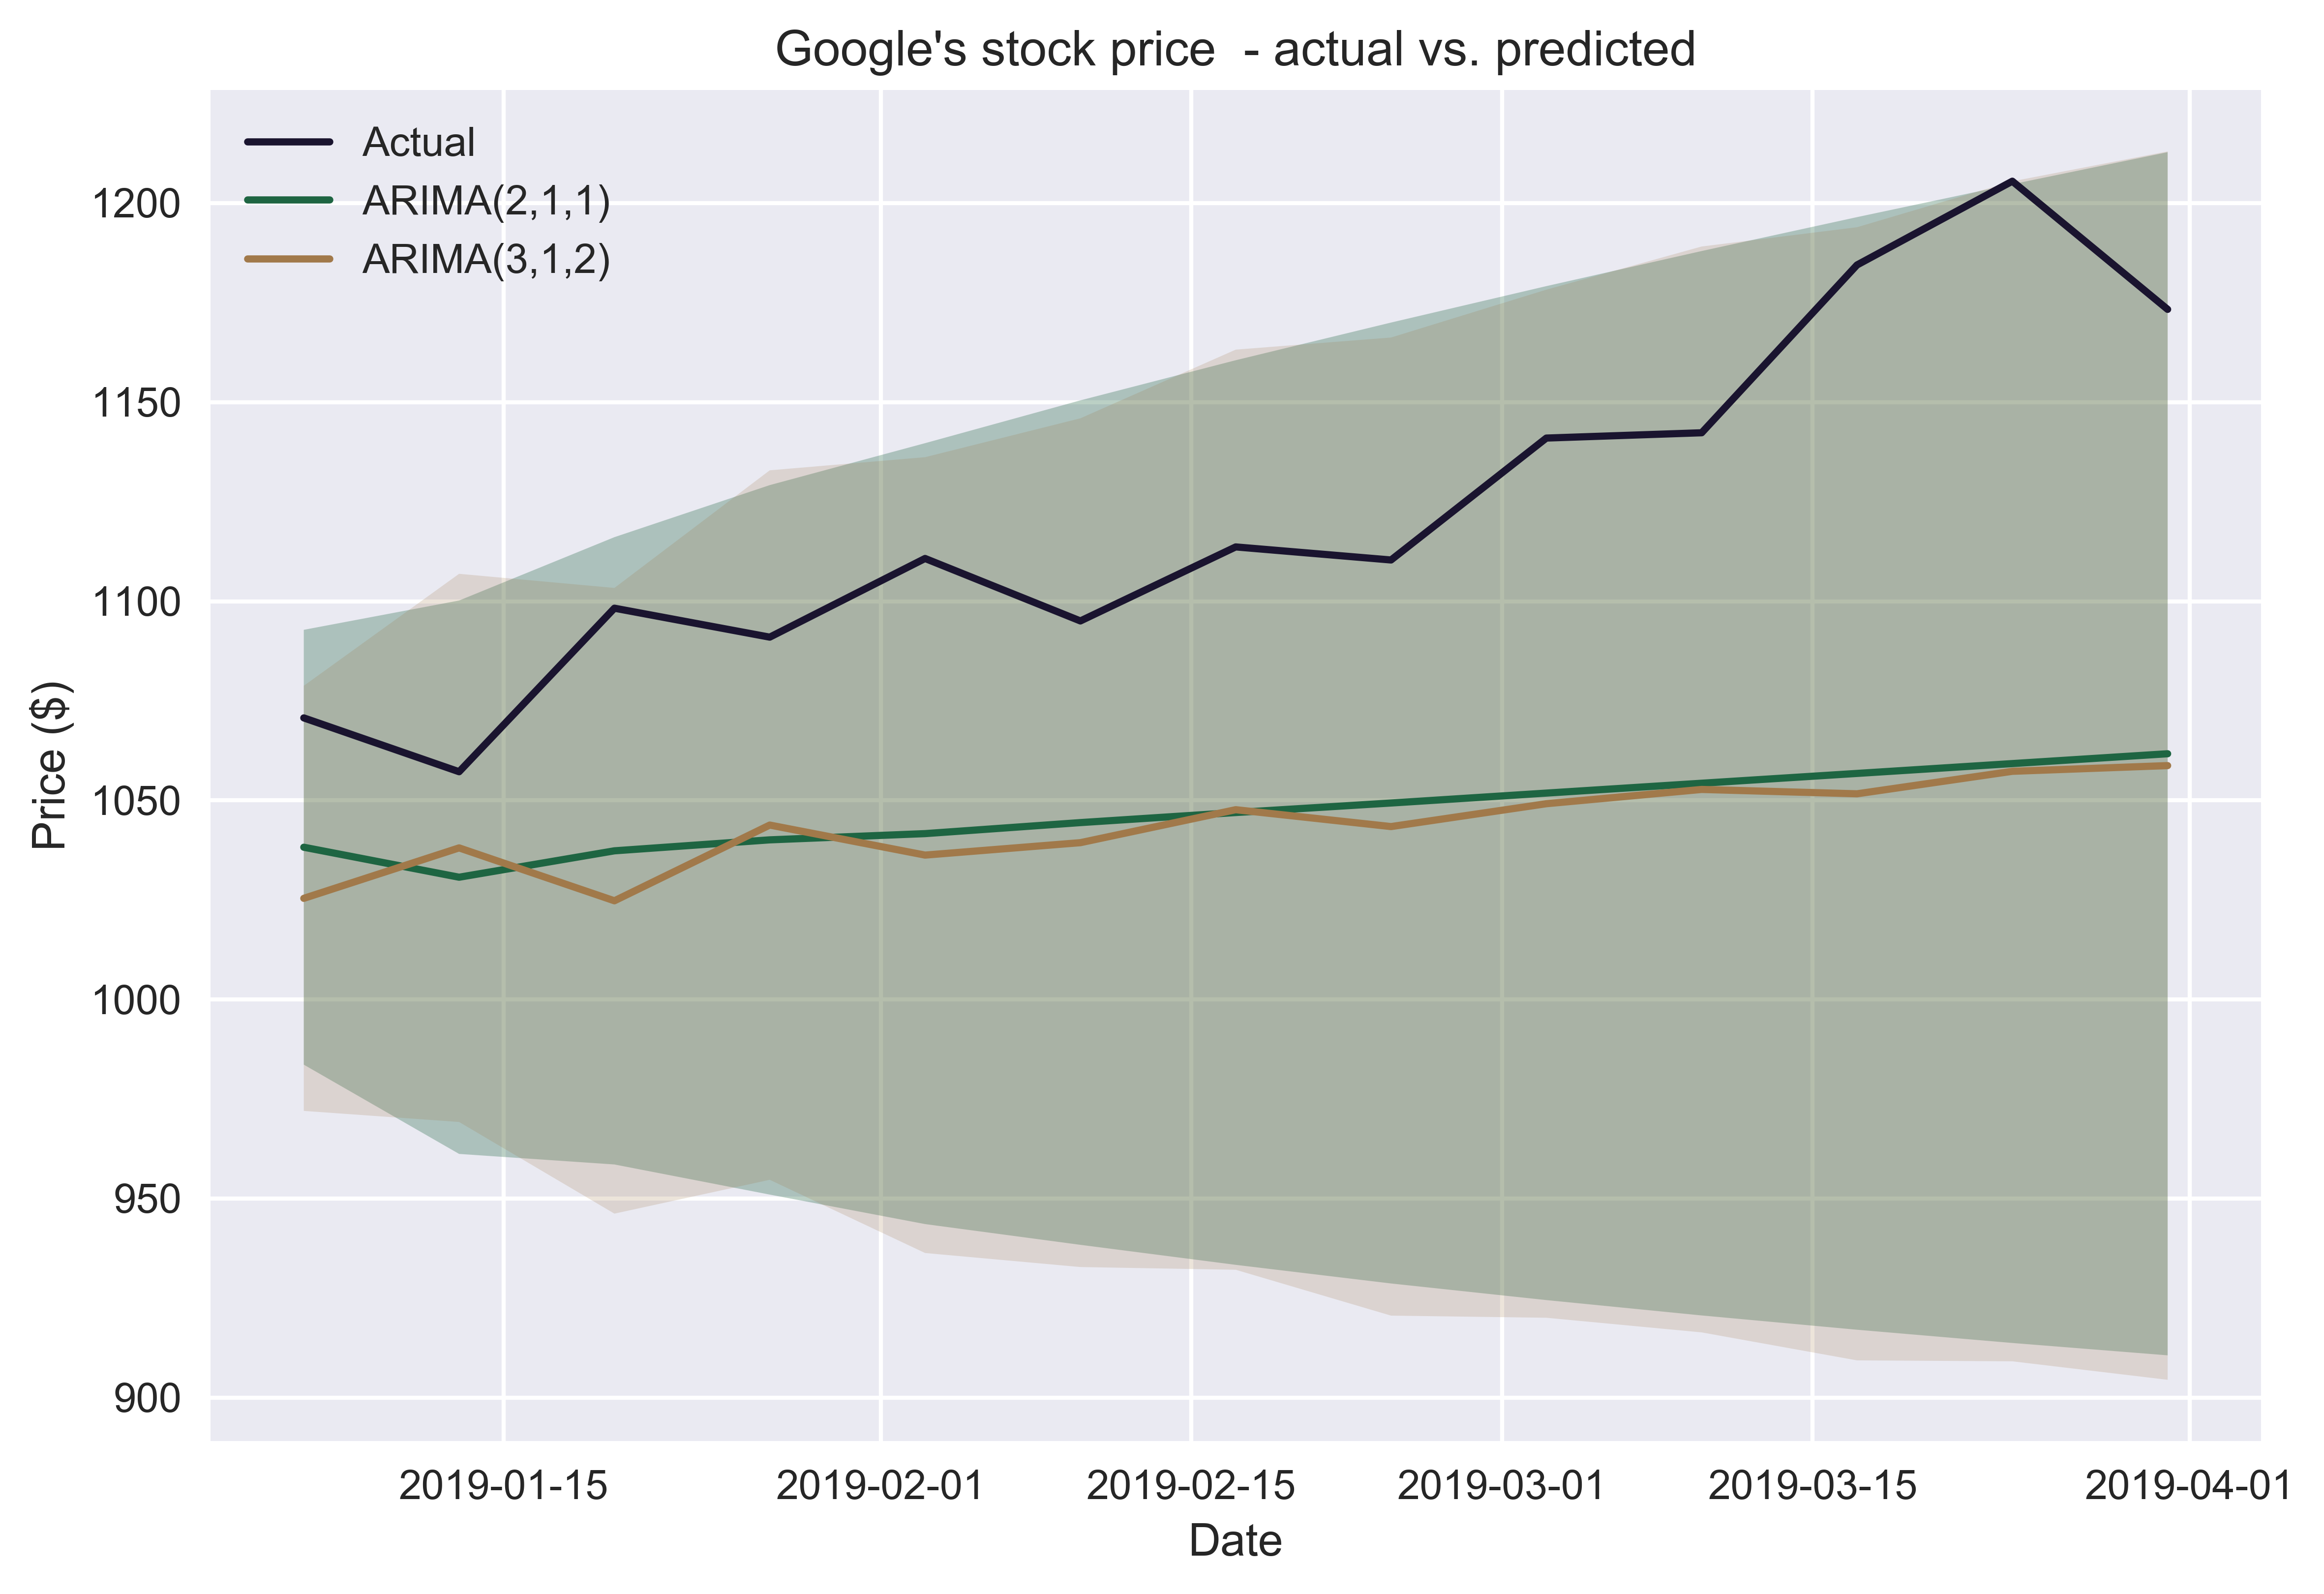

In [ ]:
fig, ax = plt.subplots(1)

ax = sns.lineplot(data=test, color=COLORS[0], label='Actual')

ax.plot(arima_pred.prediction, c=COLORS[1], label='ARIMA(2,1,1)')
ax.fill_between(arima_pred.index,
                arima_pred.ci_lower,
                arima_pred.ci_upper,
                alpha=0.3, 
                facecolor=COLORS[1])

ax.plot(auto_arima_pred.prediction, c=COLORS[2], 
        label='ARIMA(3,1,2)')
ax.fill_between(auto_arima_pred.index,
                auto_arima_pred.ci_lower,
                auto_arima_pred.ci_upper,
                alpha=0.2, 
                facecolor=COLORS[2])

ax.set(title="Google's stock price  - actual vs. predicted", 
       xlabel='Date', 
       ylabel='Price ($)')
ax.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/ch3_im25.png')
plt.show()